<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [17]</a>'.</span>

In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

from smc.smc import sequential_monte_carlo
from smc.sampling_algorithms import (
    systematic_resample,
    stratified_resample,
    multinomial_resample
)
from smc.utils import lambda_schedule
from datasets import checkerboard

from smc_scripts.plot_utils import plot_smc_results_checkerboard
from smc.proposals import (
    reverse_as_proposal, 
    first_order_approximation_optimal_proposal, 
    first_order_approximation_optimal_proposal_with_gradient_clipping
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Load pre-trained mdm model

In [2]:
from models.discrete_diffusion.udm import UniformDiffusion
from models.denoising_models.mlp import MLP

batch_size = 64
vocab_size = 256
num_categories = vocab_size
input_shape = (2,)
num_timesteps = 1000

pretrained_model = UniformDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=256,
        encode_time=True,
        n_hidden_layers=2,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    noise_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
pretrained_model.load_state_dict(torch.load('../model_weights/udm_checkerboard_256.pth'))

<All keys matched successfully>

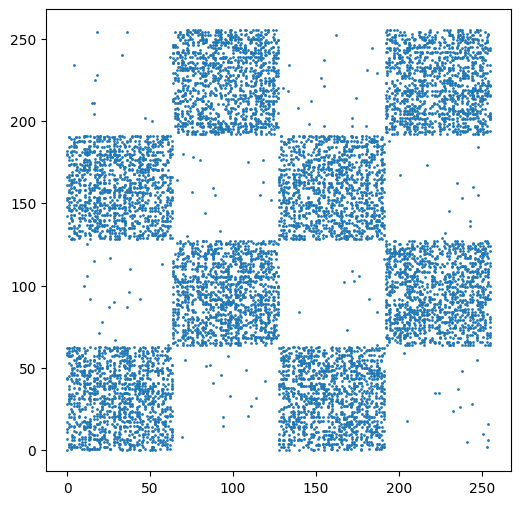

In [3]:
# Visualize pre-trained model samples
pretrained_model.eval()
with torch.no_grad():
    samples = pretrained_model.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [4]:
def compute_rewards(x: Tensor, with_grad=False):
    # x.shape : (B, 2, num_categories)
    
    x0 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    x1 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    
    reward_x0 = - (x0 - 0.5) ** 2 * 10
    reward_x1 = - (x1 - 0.5) ** 2 * 100
    
    reward = (x[:, 0] * reward_x0 + x[:, 1] * reward_x1).sum(dim=-1)
    return reward

kl_weight = 1.

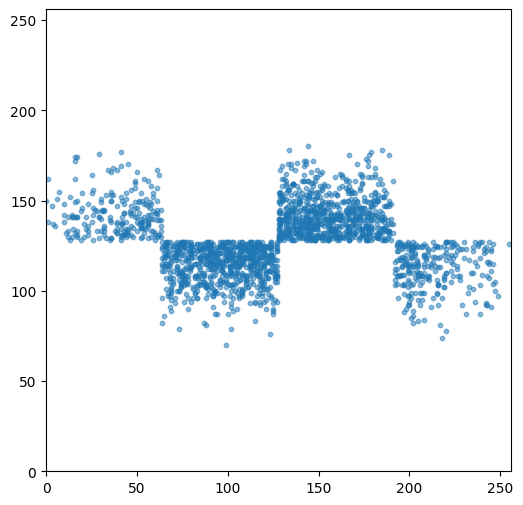

Target Reward: -0.9144218564033508
Diversity: 1692


In [5]:
def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    samples = checkerboard.generate_samples(n_grid_points=vocab_size, batch_size=n_samples * 100)
    log_pdf_values = target_distribution_log_pdf(samples, kl_weight)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return samples[indices]

target_samples = sample_target_distribution(2000, kl_weight)

plt.figure(figsize=(6, 6))
plt.scatter(target_samples[:, 0], target_samples[:, 1], s=10, alpha=0.5)
plt.xlim(0, vocab_size)
plt.ylim(0, vocab_size)
plt.show()

target_rewards = compute_rewards(F.one_hot(target_samples, num_classes=num_categories).float())
print(f"Target Reward: {target_rewards.mean().item()}")
print(f"Diversity: {np.unique(target_samples, axis=0).shape[0]}")

In [6]:
def intialize_particles(num_particles, device=device):
    particles = torch.randint(low=0, high=vocab_size, size=(num_particles, *input_shape), device=device, requires_grad=False)
    return particles

## Locally Optimal proposal

In [7]:
def compute_reward_for_x0_pred(x_0_probs: Tensor, reward_estimate_sample_count: int):
    N, L, C = x_0_probs.shape
    # Shape: (reward_estimate_sample_count, N, L)
    x_0_preds = torch.distributions.Categorical(probs=x_0_probs).sample((reward_estimate_sample_count,))
    rewards = compute_rewards(
        F.one_hot(x_0_preds.reshape(reward_estimate_sample_count * N, -1), num_classes=num_categories).float()
    ).view(reward_estimate_sample_count, N).mean(dim=0)
    return rewards

def locally_optimal_proposal(X_t, x_s_probs, t, lambdas, kl_weight, rewards_grad, model, reward_estimate_sample_count) -> tuple[Tensor, Tensor]:
    """
    Returns:
        tuple[Tensor, Tensor]: A tuple containing the proposed samples and their log probabilities.
    """
    N = len(X_t)
    
    all_rewards = torch.zeros(num_categories, num_categories, device=device)
    
    for i in range(num_categories):
        with torch.no_grad():
            x_t = F.one_hot(torch.stack([torch.full((num_categories,), i, device=device), torch.arange(num_categories, device=device)], dim=1), num_classes=num_categories).float()
            if t-1 != 0:
                _, x_0_probs = model.sample_step(x_t, t-1, device=device)
            else:
                x_0_probs = x_t
            rewards = compute_reward_for_x0_pred(x_0_probs, reward_estimate_sample_count=reward_estimate_sample_count)
            all_rewards[i, :] = rewards
        
    log_joint = torch.log(x_s_probs[:, 0, :].unsqueeze(2)) + torch.log(x_s_probs[:, 1, :].unsqueeze(1))
    log_joint += (lambdas[t-1] / kl_weight) * all_rewards.unsqueeze(0)
    log_joint -= torch.logsumexp(log_joint, dim=(1, 2), keepdim=True)
    
    indices = torch.multinomial(torch.exp(log_joint).reshape(N, -1), 1)
    X_s  = torch.cat([indices // (num_categories), indices % (num_categories)], dim=1)
    log_prob_proposal = log_joint[torch.arange(N), X_s[:, 0], X_s[:, 1]]
    
    return X_s, log_prob_proposal

In [8]:
num_particles = 2000
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=locally_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=100,
    device=device,
    verbose=True,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:03<1:01:21,  3.68s/it]

  0%|          | 2/1000 [00:04<32:18,  1.94s/it]  

  0%|          | 3/1000 [00:05<23:01,  1.39s/it]

  0%|          | 4/1000 [00:05<18:39,  1.12s/it]

  0%|          | 5/1000 [00:06<16:14,  1.02it/s]

  1%|          | 6/1000 [00:07<14:46,  1.12it/s]

  1%|          | 7/1000 [00:08<13:51,  1.19it/s]

  1%|          | 8/1000 [00:08<13:14,  1.25it/s]

  1%|          | 9/1000 [00:09<12:49,  1.29it/s]

  1%|          | 10/1000 [00:10<12:31,  1.32it/s]

  1%|          | 11/1000 [00:10<12:19,  1.34it/s]

  1%|          | 12/1000 [00:11<12:11,  1.35it/s]

  1%|▏         | 13/1000 [00:12<12:05,  1.36it/s]

  1%|▏         | 14/1000 [00:13<12:00,  1.37it/s]

  2%|▏         | 15/1000 [00:13<11:57,  1.37it/s]

  2%|▏         | 16/1000 [00:14<11:55,  1.38it/s]

  2%|▏         | 17/1000 [00:15<11:52,  1.38it/s]

  2%|▏         | 18/1000 [00:15<11:51,  1.38it/s]

  2%|▏         | 19/1000 [00:16<11:50,  1.38it/s]

  2%|▏         | 20/1000 [00:17<11:48,  1.38it/s]

  2%|▏         | 21/1000 [00:18<11:51,  1.38it/s]

  2%|▏         | 22/1000 [00:18<11:49,  1.38it/s]

  2%|▏         | 23/1000 [00:19<11:47,  1.38it/s]

  2%|▏         | 24/1000 [00:20<11:46,  1.38it/s]

  2%|▎         | 25/1000 [00:21<11:45,  1.38it/s]

  3%|▎         | 26/1000 [00:21<11:44,  1.38it/s]

  3%|▎         | 27/1000 [00:22<11:43,  1.38it/s]

  3%|▎         | 28/1000 [00:23<11:42,  1.38it/s]

  3%|▎         | 29/1000 [00:23<11:41,  1.38it/s]

  3%|▎         | 30/1000 [00:24<11:41,  1.38it/s]

  3%|▎         | 31/1000 [00:25<11:40,  1.38it/s]

  3%|▎         | 32/1000 [00:26<11:39,  1.38it/s]

  3%|▎         | 33/1000 [00:26<11:38,  1.38it/s]

  3%|▎         | 34/1000 [00:27<11:37,  1.39it/s]

  4%|▎         | 35/1000 [00:28<11:36,  1.39it/s]

  4%|▎         | 36/1000 [00:28<11:35,  1.39it/s]

  4%|▎         | 37/1000 [00:29<11:35,  1.38it/s]

  4%|▍         | 38/1000 [00:30<11:34,  1.38it/s]

  4%|▍         | 39/1000 [00:31<11:33,  1.39it/s]

  4%|▍         | 40/1000 [00:31<11:32,  1.39it/s]

  4%|▍         | 41/1000 [00:32<11:32,  1.39it/s]

  4%|▍         | 42/1000 [00:33<11:31,  1.39it/s]

  4%|▍         | 43/1000 [00:34<11:30,  1.39it/s]

  4%|▍         | 44/1000 [00:34<11:29,  1.39it/s]

  4%|▍         | 45/1000 [00:35<11:29,  1.39it/s]

  5%|▍         | 46/1000 [00:36<11:28,  1.39it/s]

  5%|▍         | 47/1000 [00:36<11:28,  1.38it/s]

  5%|▍         | 48/1000 [00:37<11:28,  1.38it/s]

  5%|▍         | 49/1000 [00:38<11:29,  1.38it/s]

  5%|▌         | 50/1000 [00:39<11:32,  1.37it/s]

  5%|▌         | 51/1000 [00:39<11:30,  1.37it/s]

  5%|▌         | 52/1000 [00:40<11:29,  1.38it/s]

  5%|▌         | 53/1000 [00:41<11:27,  1.38it/s]

  5%|▌         | 54/1000 [00:42<11:26,  1.38it/s]

  6%|▌         | 55/1000 [00:42<11:25,  1.38it/s]

  6%|▌         | 56/1000 [00:43<11:24,  1.38it/s]

  6%|▌         | 57/1000 [00:44<11:24,  1.38it/s]

  6%|▌         | 58/1000 [00:44<11:23,  1.38it/s]

  6%|▌         | 59/1000 [00:45<11:20,  1.38it/s]

  6%|▌         | 60/1000 [00:46<11:19,  1.38it/s]

  6%|▌         | 61/1000 [00:47<11:18,  1.38it/s]

  6%|▌         | 62/1000 [00:47<11:16,  1.39it/s]

  6%|▋         | 63/1000 [00:48<11:16,  1.39it/s]

  6%|▋         | 64/1000 [00:49<11:15,  1.39it/s]

  6%|▋         | 65/1000 [00:49<11:16,  1.38it/s]

  7%|▋         | 66/1000 [00:50<11:15,  1.38it/s]

  7%|▋         | 67/1000 [00:51<11:14,  1.38it/s]

  7%|▋         | 68/1000 [00:52<11:13,  1.38it/s]

  7%|▋         | 69/1000 [00:52<11:12,  1.39it/s]

  7%|▋         | 70/1000 [00:53<11:10,  1.39it/s]

  7%|▋         | 71/1000 [00:54<11:10,  1.39it/s]

  7%|▋         | 72/1000 [00:55<11:10,  1.38it/s]

  7%|▋         | 73/1000 [00:55<11:08,  1.39it/s]

  7%|▋         | 74/1000 [00:56<11:07,  1.39it/s]

  8%|▊         | 75/1000 [00:57<11:07,  1.39it/s]

  8%|▊         | 76/1000 [00:57<11:06,  1.39it/s]

  8%|▊         | 77/1000 [00:58<11:05,  1.39it/s]

  8%|▊         | 78/1000 [00:59<11:04,  1.39it/s]

  8%|▊         | 79/1000 [01:00<11:06,  1.38it/s]

  8%|▊         | 80/1000 [01:00<11:05,  1.38it/s]

  8%|▊         | 81/1000 [01:01<11:04,  1.38it/s]

  8%|▊         | 82/1000 [01:02<11:05,  1.38it/s]

  8%|▊         | 83/1000 [01:02<11:03,  1.38it/s]

  8%|▊         | 84/1000 [01:03<11:03,  1.38it/s]

  8%|▊         | 85/1000 [01:04<11:02,  1.38it/s]

  9%|▊         | 86/1000 [01:05<11:02,  1.38it/s]

  9%|▊         | 87/1000 [01:05<11:00,  1.38it/s]

  9%|▉         | 88/1000 [01:06<11:00,  1.38it/s]

  9%|▉         | 89/1000 [01:07<11:00,  1.38it/s]

  9%|▉         | 90/1000 [01:08<10:59,  1.38it/s]

  9%|▉         | 91/1000 [01:08<10:57,  1.38it/s]

  9%|▉         | 92/1000 [01:09<10:56,  1.38it/s]

  9%|▉         | 93/1000 [01:10<10:55,  1.38it/s]

  9%|▉         | 94/1000 [01:10<10:54,  1.38it/s]

 10%|▉         | 95/1000 [01:11<10:53,  1.38it/s]

 10%|▉         | 96/1000 [01:12<10:53,  1.38it/s]

 10%|▉         | 97/1000 [01:13<10:51,  1.39it/s]

 10%|▉         | 98/1000 [01:13<10:51,  1.38it/s]

 10%|▉         | 99/1000 [01:14<10:50,  1.38it/s]

 10%|█         | 100/1000 [01:15<10:50,  1.38it/s]

 10%|█         | 101/1000 [01:15<10:49,  1.38it/s]

 10%|█         | 102/1000 [01:16<10:49,  1.38it/s]

 10%|█         | 103/1000 [01:17<10:48,  1.38it/s]

 10%|█         | 104/1000 [01:18<10:49,  1.38it/s]

 10%|█         | 105/1000 [01:18<10:48,  1.38it/s]

 11%|█         | 106/1000 [01:19<10:47,  1.38it/s]

 11%|█         | 107/1000 [01:20<10:45,  1.38it/s]

 11%|█         | 108/1000 [01:21<10:45,  1.38it/s]

 11%|█         | 109/1000 [01:21<10:44,  1.38it/s]

 11%|█         | 110/1000 [01:22<10:44,  1.38it/s]

 11%|█         | 111/1000 [01:23<10:42,  1.38it/s]

 11%|█         | 112/1000 [01:23<10:42,  1.38it/s]

 11%|█▏        | 113/1000 [01:24<10:41,  1.38it/s]

 11%|█▏        | 114/1000 [01:25<10:40,  1.38it/s]

 12%|█▏        | 115/1000 [01:26<10:39,  1.38it/s]

 12%|█▏        | 116/1000 [01:26<10:39,  1.38it/s]

 12%|█▏        | 117/1000 [01:27<10:38,  1.38it/s]

 12%|█▏        | 118/1000 [01:28<10:37,  1.38it/s]

 12%|█▏        | 119/1000 [01:29<10:36,  1.38it/s]

 12%|█▏        | 120/1000 [01:29<10:35,  1.38it/s]

 12%|█▏        | 121/1000 [01:30<10:35,  1.38it/s]

 12%|█▏        | 122/1000 [01:31<10:34,  1.38it/s]

 12%|█▏        | 123/1000 [01:31<10:33,  1.38it/s]

 12%|█▏        | 124/1000 [01:32<10:32,  1.38it/s]

 12%|█▎        | 125/1000 [01:33<10:32,  1.38it/s]

 13%|█▎        | 126/1000 [01:34<10:31,  1.38it/s]

 13%|█▎        | 127/1000 [01:34<10:31,  1.38it/s]

 13%|█▎        | 128/1000 [01:35<10:30,  1.38it/s]

 13%|█▎        | 129/1000 [01:36<10:30,  1.38it/s]

 13%|█▎        | 130/1000 [01:36<10:29,  1.38it/s]

 13%|█▎        | 131/1000 [01:37<10:29,  1.38it/s]

 13%|█▎        | 132/1000 [01:38<10:29,  1.38it/s]

 13%|█▎        | 133/1000 [01:39<10:27,  1.38it/s]

 13%|█▎        | 134/1000 [01:39<10:27,  1.38it/s]

 14%|█▎        | 135/1000 [01:40<10:26,  1.38it/s]

 14%|█▎        | 136/1000 [01:41<10:25,  1.38it/s]

 14%|█▎        | 137/1000 [01:42<10:24,  1.38it/s]

 14%|█▍        | 138/1000 [01:42<10:24,  1.38it/s]

 14%|█▍        | 139/1000 [01:43<10:23,  1.38it/s]

 14%|█▍        | 140/1000 [01:44<10:22,  1.38it/s]

 14%|█▍        | 141/1000 [01:44<10:22,  1.38it/s]

 14%|█▍        | 142/1000 [01:45<10:21,  1.38it/s]

 14%|█▍        | 143/1000 [01:46<10:20,  1.38it/s]

 14%|█▍        | 144/1000 [01:47<10:19,  1.38it/s]

 14%|█▍        | 145/1000 [01:47<10:19,  1.38it/s]

 15%|█▍        | 146/1000 [01:48<10:18,  1.38it/s]

 15%|█▍        | 147/1000 [01:49<10:18,  1.38it/s]

 15%|█▍        | 148/1000 [01:49<10:17,  1.38it/s]

 15%|█▍        | 149/1000 [01:50<10:16,  1.38it/s]

 15%|█▌        | 150/1000 [01:51<10:15,  1.38it/s]

 15%|█▌        | 151/1000 [01:52<10:14,  1.38it/s]

 15%|█▌        | 152/1000 [01:52<10:13,  1.38it/s]

 15%|█▌        | 153/1000 [01:53<10:13,  1.38it/s]

 15%|█▌        | 154/1000 [01:54<10:13,  1.38it/s]

 16%|█▌        | 155/1000 [01:55<10:12,  1.38it/s]

 16%|█▌        | 156/1000 [01:55<10:12,  1.38it/s]

 16%|█▌        | 157/1000 [01:56<10:10,  1.38it/s]

 16%|█▌        | 158/1000 [01:57<10:09,  1.38it/s]

 16%|█▌        | 159/1000 [01:57<10:08,  1.38it/s]

 16%|█▌        | 160/1000 [01:58<10:07,  1.38it/s]

 16%|█▌        | 161/1000 [01:59<10:06,  1.38it/s]

 16%|█▌        | 162/1000 [02:00<10:05,  1.38it/s]

 16%|█▋        | 163/1000 [02:00<10:04,  1.39it/s]

 16%|█▋        | 164/1000 [02:01<10:03,  1.39it/s]

 16%|█▋        | 165/1000 [02:02<10:02,  1.38it/s]

 17%|█▋        | 166/1000 [02:03<10:02,  1.39it/s]

 17%|█▋        | 167/1000 [02:03<10:01,  1.38it/s]

 17%|█▋        | 168/1000 [02:04<10:01,  1.38it/s]

 17%|█▋        | 169/1000 [02:05<10:00,  1.38it/s]

 17%|█▋        | 170/1000 [02:05<10:00,  1.38it/s]

 17%|█▋        | 171/1000 [02:06<09:59,  1.38it/s]

 17%|█▋        | 172/1000 [02:07<09:58,  1.38it/s]

 17%|█▋        | 173/1000 [02:08<09:57,  1.38it/s]

 17%|█▋        | 174/1000 [02:08<09:56,  1.38it/s]

 18%|█▊        | 175/1000 [02:09<09:56,  1.38it/s]

 18%|█▊        | 176/1000 [02:10<09:55,  1.38it/s]

 18%|█▊        | 177/1000 [02:10<09:54,  1.38it/s]

 18%|█▊        | 178/1000 [02:11<09:54,  1.38it/s]

 18%|█▊        | 179/1000 [02:12<09:53,  1.38it/s]

 18%|█▊        | 180/1000 [02:13<09:53,  1.38it/s]

 18%|█▊        | 181/1000 [02:13<09:52,  1.38it/s]

 18%|█▊        | 182/1000 [02:14<09:51,  1.38it/s]

 18%|█▊        | 183/1000 [02:15<09:51,  1.38it/s]

 18%|█▊        | 184/1000 [02:16<09:49,  1.38it/s]

 18%|█▊        | 185/1000 [02:16<09:49,  1.38it/s]

 19%|█▊        | 186/1000 [02:17<09:49,  1.38it/s]

 19%|█▊        | 187/1000 [02:18<09:48,  1.38it/s]

 19%|█▉        | 188/1000 [02:18<09:47,  1.38it/s]

 19%|█▉        | 189/1000 [02:19<09:47,  1.38it/s]

 19%|█▉        | 190/1000 [02:20<09:46,  1.38it/s]

 19%|█▉        | 191/1000 [02:21<09:45,  1.38it/s]

 19%|█▉        | 192/1000 [02:21<09:44,  1.38it/s]

 19%|█▉        | 193/1000 [02:22<09:43,  1.38it/s]

 19%|█▉        | 194/1000 [02:23<09:43,  1.38it/s]

 20%|█▉        | 195/1000 [02:23<09:42,  1.38it/s]

 20%|█▉        | 196/1000 [02:24<09:41,  1.38it/s]

 20%|█▉        | 197/1000 [02:25<09:41,  1.38it/s]

 20%|█▉        | 198/1000 [02:26<09:40,  1.38it/s]

 20%|█▉        | 199/1000 [02:26<09:39,  1.38it/s]

 20%|██        | 200/1000 [02:27<09:39,  1.38it/s]

 20%|██        | 201/1000 [02:28<09:38,  1.38it/s]

 20%|██        | 202/1000 [02:29<09:37,  1.38it/s]

 20%|██        | 203/1000 [02:29<09:37,  1.38it/s]

 20%|██        | 204/1000 [02:30<09:36,  1.38it/s]

 20%|██        | 205/1000 [02:31<09:35,  1.38it/s]

 21%|██        | 206/1000 [02:31<09:35,  1.38it/s]

 21%|██        | 207/1000 [02:32<09:34,  1.38it/s]

 21%|██        | 208/1000 [02:33<09:34,  1.38it/s]

 21%|██        | 209/1000 [02:34<09:33,  1.38it/s]

 21%|██        | 210/1000 [02:34<09:33,  1.38it/s]

 21%|██        | 211/1000 [02:35<09:32,  1.38it/s]

 21%|██        | 212/1000 [02:36<09:31,  1.38it/s]

 21%|██▏       | 213/1000 [02:37<09:31,  1.38it/s]

 21%|██▏       | 214/1000 [02:37<09:30,  1.38it/s]

 22%|██▏       | 215/1000 [02:38<09:31,  1.37it/s]

 22%|██▏       | 216/1000 [02:39<09:29,  1.38it/s]

 22%|██▏       | 217/1000 [02:39<09:29,  1.38it/s]

 22%|██▏       | 218/1000 [02:40<09:28,  1.38it/s]

 22%|██▏       | 219/1000 [02:41<09:27,  1.38it/s]

 22%|██▏       | 220/1000 [02:42<09:25,  1.38it/s]

 22%|██▏       | 221/1000 [02:42<09:24,  1.38it/s]

 22%|██▏       | 222/1000 [02:43<09:23,  1.38it/s]

 22%|██▏       | 223/1000 [02:44<09:22,  1.38it/s]

 22%|██▏       | 224/1000 [02:45<09:21,  1.38it/s]

 22%|██▎       | 225/1000 [02:45<09:21,  1.38it/s]

 23%|██▎       | 226/1000 [02:46<09:21,  1.38it/s]

 23%|██▎       | 227/1000 [02:47<09:21,  1.38it/s]

 23%|██▎       | 228/1000 [02:47<09:20,  1.38it/s]

 23%|██▎       | 229/1000 [02:48<09:19,  1.38it/s]

 23%|██▎       | 230/1000 [02:49<09:18,  1.38it/s]

 23%|██▎       | 231/1000 [02:50<09:17,  1.38it/s]

 23%|██▎       | 232/1000 [02:50<09:17,  1.38it/s]

 23%|██▎       | 233/1000 [02:51<09:16,  1.38it/s]

 23%|██▎       | 234/1000 [02:52<09:16,  1.38it/s]

 24%|██▎       | 235/1000 [02:53<09:17,  1.37it/s]

 24%|██▎       | 236/1000 [02:53<09:16,  1.37it/s]

 24%|██▎       | 237/1000 [02:54<09:16,  1.37it/s]

 24%|██▍       | 238/1000 [02:55<09:15,  1.37it/s]

 24%|██▍       | 239/1000 [02:55<09:14,  1.37it/s]

 24%|██▍       | 240/1000 [02:56<09:13,  1.37it/s]

 24%|██▍       | 241/1000 [02:57<09:12,  1.37it/s]

 24%|██▍       | 242/1000 [02:58<09:11,  1.37it/s]

 24%|██▍       | 243/1000 [02:58<09:11,  1.37it/s]

 24%|██▍       | 244/1000 [02:59<09:10,  1.37it/s]

 24%|██▍       | 245/1000 [03:00<09:09,  1.37it/s]

 25%|██▍       | 246/1000 [03:01<09:08,  1.37it/s]

 25%|██▍       | 247/1000 [03:01<09:08,  1.37it/s]

 25%|██▍       | 248/1000 [03:02<09:07,  1.37it/s]

 25%|██▍       | 249/1000 [03:03<09:06,  1.37it/s]

 25%|██▌       | 250/1000 [03:03<09:06,  1.37it/s]

 25%|██▌       | 251/1000 [03:04<09:05,  1.37it/s]

 25%|██▌       | 252/1000 [03:05<09:04,  1.37it/s]

 25%|██▌       | 253/1000 [03:06<09:04,  1.37it/s]

 25%|██▌       | 254/1000 [03:06<09:03,  1.37it/s]

 26%|██▌       | 255/1000 [03:07<09:02,  1.37it/s]

 26%|██▌       | 256/1000 [03:08<09:02,  1.37it/s]

 26%|██▌       | 257/1000 [03:09<09:01,  1.37it/s]

 26%|██▌       | 258/1000 [03:09<09:01,  1.37it/s]

 26%|██▌       | 259/1000 [03:10<09:00,  1.37it/s]

 26%|██▌       | 260/1000 [03:11<08:59,  1.37it/s]

 26%|██▌       | 261/1000 [03:11<08:58,  1.37it/s]

 26%|██▌       | 262/1000 [03:12<08:57,  1.37it/s]

 26%|██▋       | 263/1000 [03:13<08:57,  1.37it/s]

 26%|██▋       | 264/1000 [03:14<08:57,  1.37it/s]

 26%|██▋       | 265/1000 [03:14<08:56,  1.37it/s]

 27%|██▋       | 266/1000 [03:15<08:55,  1.37it/s]

 27%|██▋       | 267/1000 [03:16<08:54,  1.37it/s]

 27%|██▋       | 268/1000 [03:17<08:53,  1.37it/s]

 27%|██▋       | 269/1000 [03:17<08:53,  1.37it/s]

 27%|██▋       | 270/1000 [03:18<08:52,  1.37it/s]

 27%|██▋       | 271/1000 [03:19<08:51,  1.37it/s]

 27%|██▋       | 272/1000 [03:19<08:50,  1.37it/s]

 27%|██▋       | 273/1000 [03:20<08:50,  1.37it/s]

 27%|██▋       | 274/1000 [03:21<08:49,  1.37it/s]

 28%|██▊       | 275/1000 [03:22<08:48,  1.37it/s]

 28%|██▊       | 276/1000 [03:22<08:47,  1.37it/s]

 28%|██▊       | 277/1000 [03:23<08:46,  1.37it/s]

 28%|██▊       | 278/1000 [03:24<08:46,  1.37it/s]

 28%|██▊       | 279/1000 [03:25<08:45,  1.37it/s]

 28%|██▊       | 280/1000 [03:25<08:44,  1.37it/s]

 28%|██▊       | 281/1000 [03:26<08:44,  1.37it/s]

 28%|██▊       | 282/1000 [03:27<08:43,  1.37it/s]

 28%|██▊       | 283/1000 [03:28<08:42,  1.37it/s]

 28%|██▊       | 284/1000 [03:28<08:42,  1.37it/s]

 28%|██▊       | 285/1000 [03:29<08:41,  1.37it/s]

 29%|██▊       | 286/1000 [03:30<08:40,  1.37it/s]

 29%|██▊       | 287/1000 [03:30<08:39,  1.37it/s]

 29%|██▉       | 288/1000 [03:31<08:39,  1.37it/s]

 29%|██▉       | 289/1000 [03:32<08:38,  1.37it/s]

 29%|██▉       | 290/1000 [03:33<08:39,  1.37it/s]

 29%|██▉       | 291/1000 [03:33<08:37,  1.37it/s]

 29%|██▉       | 292/1000 [03:34<08:36,  1.37it/s]

 29%|██▉       | 293/1000 [03:35<08:35,  1.37it/s]

 29%|██▉       | 294/1000 [03:36<08:35,  1.37it/s]

 30%|██▉       | 295/1000 [03:36<08:34,  1.37it/s]

 30%|██▉       | 296/1000 [03:37<08:33,  1.37it/s]

 30%|██▉       | 297/1000 [03:38<08:33,  1.37it/s]

 30%|██▉       | 298/1000 [03:38<08:33,  1.37it/s]

 30%|██▉       | 299/1000 [03:39<08:32,  1.37it/s]

 30%|███       | 300/1000 [03:40<08:31,  1.37it/s]

 30%|███       | 301/1000 [03:41<08:30,  1.37it/s]

 30%|███       | 302/1000 [03:41<08:29,  1.37it/s]

 30%|███       | 303/1000 [03:42<08:28,  1.37it/s]

 30%|███       | 304/1000 [03:43<08:27,  1.37it/s]

 30%|███       | 305/1000 [03:44<08:26,  1.37it/s]

 31%|███       | 306/1000 [03:44<08:25,  1.37it/s]

 31%|███       | 307/1000 [03:45<08:25,  1.37it/s]

 31%|███       | 308/1000 [03:46<08:24,  1.37it/s]

 31%|███       | 309/1000 [03:46<08:24,  1.37it/s]

 31%|███       | 310/1000 [03:47<08:23,  1.37it/s]

 31%|███       | 311/1000 [03:48<08:22,  1.37it/s]

 31%|███       | 312/1000 [03:49<08:21,  1.37it/s]

 31%|███▏      | 313/1000 [03:49<08:20,  1.37it/s]

 31%|███▏      | 314/1000 [03:50<08:19,  1.37it/s]

 32%|███▏      | 315/1000 [03:51<08:18,  1.37it/s]

 32%|███▏      | 316/1000 [03:52<08:18,  1.37it/s]

 32%|███▏      | 317/1000 [03:52<08:17,  1.37it/s]

 32%|███▏      | 318/1000 [03:53<08:17,  1.37it/s]

 32%|███▏      | 319/1000 [03:54<08:16,  1.37it/s]

 32%|███▏      | 320/1000 [03:54<08:15,  1.37it/s]

 32%|███▏      | 321/1000 [03:55<08:14,  1.37it/s]

 32%|███▏      | 322/1000 [03:56<08:14,  1.37it/s]

 32%|███▏      | 323/1000 [03:57<08:13,  1.37it/s]

 32%|███▏      | 324/1000 [03:57<08:12,  1.37it/s]

 32%|███▎      | 325/1000 [03:58<08:11,  1.37it/s]

 33%|███▎      | 326/1000 [03:59<08:10,  1.37it/s]

 33%|███▎      | 327/1000 [04:00<08:10,  1.37it/s]

 33%|███▎      | 328/1000 [04:00<08:09,  1.37it/s]

 33%|███▎      | 329/1000 [04:01<08:08,  1.37it/s]

 33%|███▎      | 330/1000 [04:02<08:08,  1.37it/s]

 33%|███▎      | 331/1000 [04:03<08:07,  1.37it/s]

 33%|███▎      | 332/1000 [04:03<08:06,  1.37it/s]

 33%|███▎      | 333/1000 [04:04<08:05,  1.37it/s]

 33%|███▎      | 334/1000 [04:05<08:04,  1.37it/s]

 34%|███▎      | 335/1000 [04:05<08:04,  1.37it/s]

 34%|███▎      | 336/1000 [04:06<08:03,  1.37it/s]

 34%|███▎      | 337/1000 [04:07<08:03,  1.37it/s]

 34%|███▍      | 338/1000 [04:08<08:02,  1.37it/s]

 34%|███▍      | 339/1000 [04:08<08:01,  1.37it/s]

 34%|███▍      | 340/1000 [04:09<08:00,  1.37it/s]

 34%|███▍      | 341/1000 [04:10<07:59,  1.37it/s]

 34%|███▍      | 342/1000 [04:11<07:59,  1.37it/s]

 34%|███▍      | 343/1000 [04:11<07:58,  1.37it/s]

 34%|███▍      | 344/1000 [04:12<07:57,  1.37it/s]

 34%|███▍      | 345/1000 [04:13<07:56,  1.37it/s]

 35%|███▍      | 346/1000 [04:13<07:56,  1.37it/s]

 35%|███▍      | 347/1000 [04:14<07:55,  1.37it/s]

 35%|███▍      | 348/1000 [04:15<07:54,  1.37it/s]

 35%|███▍      | 349/1000 [04:16<07:54,  1.37it/s]

 35%|███▌      | 350/1000 [04:16<07:53,  1.37it/s]

 35%|███▌      | 351/1000 [04:17<07:53,  1.37it/s]

 35%|███▌      | 352/1000 [04:18<07:53,  1.37it/s]

 35%|███▌      | 353/1000 [04:19<07:51,  1.37it/s]

 35%|███▌      | 354/1000 [04:19<07:51,  1.37it/s]

 36%|███▌      | 355/1000 [04:20<07:49,  1.37it/s]

 36%|███▌      | 356/1000 [04:21<07:49,  1.37it/s]

 36%|███▌      | 357/1000 [04:21<07:48,  1.37it/s]

 36%|███▌      | 358/1000 [04:22<07:47,  1.37it/s]

 36%|███▌      | 359/1000 [04:23<07:46,  1.37it/s]

 36%|███▌      | 360/1000 [04:24<07:45,  1.37it/s]

 36%|███▌      | 361/1000 [04:24<07:45,  1.37it/s]

 36%|███▌      | 362/1000 [04:25<07:44,  1.37it/s]

 36%|███▋      | 363/1000 [04:26<07:43,  1.37it/s]

 36%|███▋      | 364/1000 [04:27<07:42,  1.37it/s]

 36%|███▋      | 365/1000 [04:27<07:42,  1.37it/s]

 37%|███▋      | 366/1000 [04:28<07:41,  1.37it/s]

 37%|███▋      | 367/1000 [04:29<07:41,  1.37it/s]

 37%|███▋      | 368/1000 [04:29<07:41,  1.37it/s]

 37%|███▋      | 369/1000 [04:30<07:40,  1.37it/s]

 37%|███▋      | 370/1000 [04:31<07:39,  1.37it/s]

 37%|███▋      | 371/1000 [04:32<07:38,  1.37it/s]

 37%|███▋      | 372/1000 [04:32<07:37,  1.37it/s]

 37%|███▋      | 373/1000 [04:33<07:36,  1.37it/s]

 37%|███▋      | 374/1000 [04:34<07:35,  1.37it/s]

 38%|███▊      | 375/1000 [04:35<07:34,  1.38it/s]

 38%|███▊      | 376/1000 [04:35<07:34,  1.37it/s]

 38%|███▊      | 377/1000 [04:36<07:33,  1.37it/s]

 38%|███▊      | 378/1000 [04:37<07:32,  1.37it/s]

 38%|███▊      | 379/1000 [04:37<07:32,  1.37it/s]

 38%|███▊      | 380/1000 [04:38<07:32,  1.37it/s]

 38%|███▊      | 381/1000 [04:39<07:31,  1.37it/s]

 38%|███▊      | 382/1000 [04:40<07:31,  1.37it/s]

 38%|███▊      | 383/1000 [04:40<07:30,  1.37it/s]

 38%|███▊      | 384/1000 [04:41<07:29,  1.37it/s]

 38%|███▊      | 385/1000 [04:42<07:27,  1.37it/s]

 39%|███▊      | 386/1000 [04:43<07:27,  1.37it/s]

 39%|███▊      | 387/1000 [04:43<07:26,  1.37it/s]

 39%|███▉      | 388/1000 [04:44<07:25,  1.37it/s]

 39%|███▉      | 389/1000 [04:45<07:25,  1.37it/s]

 39%|███▉      | 390/1000 [04:45<07:24,  1.37it/s]

 39%|███▉      | 391/1000 [04:46<07:24,  1.37it/s]

 39%|███▉      | 392/1000 [04:47<07:23,  1.37it/s]

 39%|███▉      | 393/1000 [04:48<07:22,  1.37it/s]

 39%|███▉      | 394/1000 [04:48<07:21,  1.37it/s]

 40%|███▉      | 395/1000 [04:49<07:20,  1.37it/s]

 40%|███▉      | 396/1000 [04:50<07:19,  1.37it/s]

 40%|███▉      | 397/1000 [04:51<07:19,  1.37it/s]

 40%|███▉      | 398/1000 [04:51<07:18,  1.37it/s]

 40%|███▉      | 399/1000 [04:52<07:18,  1.37it/s]

 40%|████      | 400/1000 [04:53<07:17,  1.37it/s]

 40%|████      | 401/1000 [04:54<07:16,  1.37it/s]

 40%|████      | 402/1000 [04:54<07:15,  1.37it/s]

 40%|████      | 403/1000 [04:55<07:14,  1.37it/s]

 40%|████      | 404/1000 [04:56<07:14,  1.37it/s]

 40%|████      | 405/1000 [04:56<07:13,  1.37it/s]

 41%|████      | 406/1000 [04:57<07:12,  1.37it/s]

 41%|████      | 407/1000 [04:58<07:12,  1.37it/s]

 41%|████      | 408/1000 [04:59<07:11,  1.37it/s]

 41%|████      | 409/1000 [04:59<07:10,  1.37it/s]

 41%|████      | 410/1000 [05:00<07:10,  1.37it/s]

 41%|████      | 411/1000 [05:01<07:09,  1.37it/s]

 41%|████      | 412/1000 [05:02<07:08,  1.37it/s]

 41%|████▏     | 413/1000 [05:02<07:07,  1.37it/s]

 41%|████▏     | 414/1000 [05:03<07:06,  1.37it/s]

 42%|████▏     | 415/1000 [05:04<07:05,  1.37it/s]

 42%|████▏     | 416/1000 [05:04<07:05,  1.37it/s]

 42%|████▏     | 417/1000 [05:05<07:04,  1.37it/s]

 42%|████▏     | 418/1000 [05:06<07:03,  1.37it/s]

 42%|████▏     | 419/1000 [05:07<07:02,  1.37it/s]

 42%|████▏     | 420/1000 [05:07<07:02,  1.37it/s]

 42%|████▏     | 421/1000 [05:08<07:01,  1.37it/s]

 42%|████▏     | 422/1000 [05:09<07:01,  1.37it/s]

 42%|████▏     | 423/1000 [05:10<07:00,  1.37it/s]

 42%|████▏     | 424/1000 [05:10<06:59,  1.37it/s]

 42%|████▎     | 425/1000 [05:11<06:58,  1.37it/s]

 43%|████▎     | 426/1000 [05:12<06:57,  1.38it/s]

 43%|████▎     | 427/1000 [05:12<06:57,  1.37it/s]

 43%|████▎     | 428/1000 [05:13<06:56,  1.37it/s]

 43%|████▎     | 429/1000 [05:14<06:55,  1.37it/s]

 43%|████▎     | 430/1000 [05:15<06:55,  1.37it/s]

 43%|████▎     | 431/1000 [05:15<06:55,  1.37it/s]

 43%|████▎     | 432/1000 [05:16<06:53,  1.37it/s]

 43%|████▎     | 433/1000 [05:17<06:52,  1.37it/s]

 43%|████▎     | 434/1000 [05:18<06:52,  1.37it/s]

 44%|████▎     | 435/1000 [05:18<06:51,  1.37it/s]

 44%|████▎     | 436/1000 [05:19<06:50,  1.37it/s]

 44%|████▎     | 437/1000 [05:20<06:50,  1.37it/s]

 44%|████▍     | 438/1000 [05:20<06:49,  1.37it/s]

 44%|████▍     | 439/1000 [05:21<06:48,  1.37it/s]

 44%|████▍     | 440/1000 [05:22<06:47,  1.37it/s]

 44%|████▍     | 441/1000 [05:23<06:47,  1.37it/s]

 44%|████▍     | 442/1000 [05:23<06:46,  1.37it/s]

 44%|████▍     | 443/1000 [05:24<06:45,  1.37it/s]

 44%|████▍     | 444/1000 [05:25<06:45,  1.37it/s]

 44%|████▍     | 445/1000 [05:26<06:44,  1.37it/s]

 45%|████▍     | 446/1000 [05:26<06:43,  1.37it/s]

 45%|████▍     | 447/1000 [05:27<06:42,  1.37it/s]

 45%|████▍     | 448/1000 [05:28<06:42,  1.37it/s]

 45%|████▍     | 449/1000 [05:28<06:41,  1.37it/s]

 45%|████▌     | 450/1000 [05:29<06:40,  1.37it/s]

 45%|████▌     | 451/1000 [05:30<06:40,  1.37it/s]

 45%|████▌     | 452/1000 [05:31<06:40,  1.37it/s]

 45%|████▌     | 453/1000 [05:31<06:39,  1.37it/s]

 45%|████▌     | 454/1000 [05:32<06:38,  1.37it/s]

 46%|████▌     | 455/1000 [05:33<06:37,  1.37it/s]

 46%|████▌     | 456/1000 [05:34<06:36,  1.37it/s]

 46%|████▌     | 457/1000 [05:34<06:35,  1.37it/s]

 46%|████▌     | 458/1000 [05:35<06:34,  1.37it/s]

 46%|████▌     | 459/1000 [05:36<06:33,  1.37it/s]

 46%|████▌     | 460/1000 [05:36<06:33,  1.37it/s]

 46%|████▌     | 461/1000 [05:37<06:32,  1.37it/s]

 46%|████▌     | 462/1000 [05:38<06:31,  1.37it/s]

 46%|████▋     | 463/1000 [05:39<06:30,  1.37it/s]

 46%|████▋     | 464/1000 [05:39<06:30,  1.37it/s]

 46%|████▋     | 465/1000 [05:40<06:29,  1.37it/s]

 47%|████▋     | 466/1000 [05:41<06:28,  1.37it/s]

 47%|████▋     | 467/1000 [05:42<06:27,  1.37it/s]

 47%|████▋     | 468/1000 [05:42<06:27,  1.37it/s]

 47%|████▋     | 469/1000 [05:43<06:26,  1.37it/s]

 47%|████▋     | 470/1000 [05:44<06:25,  1.37it/s]

 47%|████▋     | 471/1000 [05:44<06:24,  1.37it/s]

 47%|████▋     | 472/1000 [05:45<06:24,  1.37it/s]

 47%|████▋     | 473/1000 [05:46<06:23,  1.37it/s]

 47%|████▋     | 474/1000 [05:47<06:23,  1.37it/s]

 48%|████▊     | 475/1000 [05:47<06:22,  1.37it/s]

 48%|████▊     | 476/1000 [05:48<06:21,  1.37it/s]

 48%|████▊     | 477/1000 [05:49<06:20,  1.37it/s]

 48%|████▊     | 478/1000 [05:50<06:20,  1.37it/s]

 48%|████▊     | 479/1000 [05:50<06:19,  1.37it/s]

 48%|████▊     | 480/1000 [05:51<06:18,  1.37it/s]

 48%|████▊     | 481/1000 [05:52<06:18,  1.37it/s]

 48%|████▊     | 482/1000 [05:53<06:18,  1.37it/s]

 48%|████▊     | 483/1000 [05:53<06:17,  1.37it/s]

 48%|████▊     | 484/1000 [05:54<06:15,  1.37it/s]

 48%|████▊     | 485/1000 [05:55<06:14,  1.37it/s]

 49%|████▊     | 486/1000 [05:55<06:13,  1.37it/s]

 49%|████▊     | 487/1000 [05:56<06:12,  1.38it/s]

 49%|████▉     | 488/1000 [05:57<06:11,  1.38it/s]

 49%|████▉     | 489/1000 [05:58<06:11,  1.38it/s]

 49%|████▉     | 490/1000 [05:58<06:10,  1.38it/s]

 49%|████▉     | 491/1000 [05:59<06:09,  1.38it/s]

 49%|████▉     | 492/1000 [06:00<06:08,  1.38it/s]

 49%|████▉     | 493/1000 [06:01<06:08,  1.38it/s]

 49%|████▉     | 494/1000 [06:01<06:07,  1.38it/s]

 50%|████▉     | 495/1000 [06:02<06:06,  1.38it/s]

 50%|████▉     | 496/1000 [06:03<06:05,  1.38it/s]

 50%|████▉     | 497/1000 [06:03<06:05,  1.38it/s]

 50%|████▉     | 498/1000 [06:04<06:04,  1.38it/s]

 50%|████▉     | 499/1000 [06:05<06:03,  1.38it/s]

 50%|█████     | 500/1000 [06:06<06:03,  1.38it/s]

 50%|█████     | 501/1000 [06:06<06:02,  1.38it/s]

 50%|█████     | 502/1000 [06:07<06:01,  1.38it/s]

 50%|█████     | 503/1000 [06:08<06:00,  1.38it/s]

 50%|█████     | 504/1000 [06:08<05:59,  1.38it/s]

 50%|█████     | 505/1000 [06:09<05:59,  1.38it/s]

 51%|█████     | 506/1000 [06:10<05:58,  1.38it/s]

 51%|█████     | 507/1000 [06:11<05:57,  1.38it/s]

 51%|█████     | 508/1000 [06:11<05:57,  1.38it/s]

 51%|█████     | 509/1000 [06:12<05:56,  1.38it/s]

 51%|█████     | 510/1000 [06:13<05:55,  1.38it/s]

 51%|█████     | 511/1000 [06:14<05:54,  1.38it/s]

 51%|█████     | 512/1000 [06:14<05:53,  1.38it/s]

 51%|█████▏    | 513/1000 [06:15<05:53,  1.38it/s]

 51%|█████▏    | 514/1000 [06:16<05:52,  1.38it/s]

 52%|█████▏    | 515/1000 [06:16<05:51,  1.38it/s]

 52%|█████▏    | 516/1000 [06:17<05:51,  1.38it/s]

 52%|█████▏    | 517/1000 [06:18<05:50,  1.38it/s]

 52%|█████▏    | 518/1000 [06:19<05:49,  1.38it/s]

 52%|█████▏    | 519/1000 [06:19<05:48,  1.38it/s]

 52%|█████▏    | 520/1000 [06:20<05:48,  1.38it/s]

 52%|█████▏    | 521/1000 [06:21<05:47,  1.38it/s]

 52%|█████▏    | 522/1000 [06:22<05:46,  1.38it/s]

 52%|█████▏    | 523/1000 [06:22<05:46,  1.38it/s]

 52%|█████▏    | 524/1000 [06:23<05:45,  1.38it/s]

 52%|█████▎    | 525/1000 [06:24<05:44,  1.38it/s]

 53%|█████▎    | 526/1000 [06:24<05:44,  1.38it/s]

 53%|█████▎    | 527/1000 [06:25<05:43,  1.38it/s]

 53%|█████▎    | 528/1000 [06:26<05:42,  1.38it/s]

 53%|█████▎    | 529/1000 [06:27<05:41,  1.38it/s]

 53%|█████▎    | 530/1000 [06:27<05:41,  1.38it/s]

 53%|█████▎    | 531/1000 [06:28<05:40,  1.38it/s]

 53%|█████▎    | 532/1000 [06:29<05:39,  1.38it/s]

 53%|█████▎    | 533/1000 [06:30<05:39,  1.38it/s]

 53%|█████▎    | 534/1000 [06:30<05:38,  1.37it/s]

 54%|█████▎    | 535/1000 [06:31<05:38,  1.37it/s]

 54%|█████▎    | 536/1000 [06:32<05:37,  1.37it/s]

 54%|█████▎    | 537/1000 [06:32<05:36,  1.38it/s]

 54%|█████▍    | 538/1000 [06:33<05:35,  1.38it/s]

 54%|█████▍    | 539/1000 [06:34<05:34,  1.38it/s]

 54%|█████▍    | 540/1000 [06:35<05:34,  1.38it/s]

 54%|█████▍    | 541/1000 [06:35<05:33,  1.38it/s]

 54%|█████▍    | 542/1000 [06:36<05:32,  1.38it/s]

 54%|█████▍    | 543/1000 [06:37<05:31,  1.38it/s]

 54%|█████▍    | 544/1000 [06:38<05:31,  1.38it/s]

 55%|█████▍    | 545/1000 [06:38<05:30,  1.38it/s]

 55%|█████▍    | 546/1000 [06:39<05:29,  1.38it/s]

 55%|█████▍    | 547/1000 [06:40<05:28,  1.38it/s]

 55%|█████▍    | 548/1000 [06:40<05:28,  1.38it/s]

 55%|█████▍    | 549/1000 [06:41<05:27,  1.38it/s]

 55%|█████▌    | 550/1000 [06:42<05:26,  1.38it/s]

 55%|█████▌    | 551/1000 [06:43<05:26,  1.37it/s]

 55%|█████▌    | 552/1000 [06:43<05:25,  1.38it/s]

 55%|█████▌    | 553/1000 [06:44<05:24,  1.38it/s]

 55%|█████▌    | 554/1000 [06:45<05:24,  1.38it/s]

 56%|█████▌    | 555/1000 [06:46<05:23,  1.38it/s]

 56%|█████▌    | 556/1000 [06:46<05:22,  1.38it/s]

 56%|█████▌    | 557/1000 [06:47<05:22,  1.38it/s]

 56%|█████▌    | 558/1000 [06:48<05:21,  1.37it/s]

 56%|█████▌    | 559/1000 [06:48<05:20,  1.37it/s]

 56%|█████▌    | 560/1000 [06:49<05:20,  1.37it/s]

 56%|█████▌    | 561/1000 [06:50<05:19,  1.37it/s]

 56%|█████▌    | 562/1000 [06:51<05:18,  1.37it/s]

 56%|█████▋    | 563/1000 [06:51<05:18,  1.37it/s]

 56%|█████▋    | 564/1000 [06:52<05:17,  1.37it/s]

 56%|█████▋    | 565/1000 [06:53<05:16,  1.37it/s]

 57%|█████▋    | 566/1000 [06:54<05:16,  1.37it/s]

 57%|█████▋    | 567/1000 [06:54<05:15,  1.37it/s]

 57%|█████▋    | 568/1000 [06:55<05:14,  1.37it/s]

 57%|█████▋    | 569/1000 [06:56<05:13,  1.37it/s]

 57%|█████▋    | 570/1000 [06:56<05:13,  1.37it/s]

 57%|█████▋    | 571/1000 [06:57<05:12,  1.37it/s]

 57%|█████▋    | 572/1000 [06:58<05:11,  1.37it/s]

 57%|█████▋    | 573/1000 [06:59<05:10,  1.37it/s]

 57%|█████▋    | 574/1000 [06:59<05:10,  1.37it/s]

 57%|█████▊    | 575/1000 [07:00<05:09,  1.37it/s]

 58%|█████▊    | 576/1000 [07:01<05:09,  1.37it/s]

 58%|█████▊    | 577/1000 [07:02<05:08,  1.37it/s]

 58%|█████▊    | 578/1000 [07:02<05:07,  1.37it/s]

 58%|█████▊    | 579/1000 [07:03<05:06,  1.37it/s]

 58%|█████▊    | 580/1000 [07:04<05:05,  1.37it/s]

 58%|█████▊    | 581/1000 [07:04<05:05,  1.37it/s]

 58%|█████▊    | 582/1000 [07:05<05:04,  1.37it/s]

 58%|█████▊    | 583/1000 [07:06<05:03,  1.37it/s]

 58%|█████▊    | 584/1000 [07:07<05:02,  1.37it/s]

 58%|█████▊    | 585/1000 [07:07<05:02,  1.37it/s]

 59%|█████▊    | 586/1000 [07:08<05:01,  1.37it/s]

 59%|█████▊    | 587/1000 [07:09<05:00,  1.37it/s]

 59%|█████▉    | 588/1000 [07:10<05:00,  1.37it/s]

 59%|█████▉    | 589/1000 [07:10<04:59,  1.37it/s]

 59%|█████▉    | 590/1000 [07:11<04:58,  1.37it/s]

 59%|█████▉    | 591/1000 [07:12<04:58,  1.37it/s]

 59%|█████▉    | 592/1000 [07:12<04:56,  1.37it/s]

 59%|█████▉    | 593/1000 [07:13<04:56,  1.37it/s]

 59%|█████▉    | 594/1000 [07:14<04:55,  1.37it/s]

 60%|█████▉    | 595/1000 [07:15<04:54,  1.37it/s]

 60%|█████▉    | 596/1000 [07:15<04:54,  1.37it/s]

 60%|█████▉    | 597/1000 [07:16<04:53,  1.37it/s]

 60%|█████▉    | 598/1000 [07:17<04:52,  1.37it/s]

 60%|█████▉    | 599/1000 [07:18<04:51,  1.37it/s]

 60%|██████    | 600/1000 [07:18<04:51,  1.37it/s]

 60%|██████    | 601/1000 [07:19<04:50,  1.37it/s]

 60%|██████    | 602/1000 [07:20<04:49,  1.37it/s]

 60%|██████    | 603/1000 [07:20<04:49,  1.37it/s]

 60%|██████    | 604/1000 [07:21<04:48,  1.37it/s]

 60%|██████    | 605/1000 [07:22<04:47,  1.37it/s]

 61%|██████    | 606/1000 [07:23<04:46,  1.37it/s]

 61%|██████    | 607/1000 [07:23<04:46,  1.37it/s]

 61%|██████    | 608/1000 [07:24<04:45,  1.37it/s]

 61%|██████    | 609/1000 [07:25<04:44,  1.37it/s]

 61%|██████    | 610/1000 [07:26<04:44,  1.37it/s]

 61%|██████    | 611/1000 [07:26<04:43,  1.37it/s]

 61%|██████    | 612/1000 [07:27<04:42,  1.37it/s]

 61%|██████▏   | 613/1000 [07:28<04:42,  1.37it/s]

 61%|██████▏   | 614/1000 [07:28<04:41,  1.37it/s]

 62%|██████▏   | 615/1000 [07:29<04:40,  1.37it/s]

 62%|██████▏   | 616/1000 [07:30<04:39,  1.37it/s]

 62%|██████▏   | 617/1000 [07:31<04:39,  1.37it/s]

 62%|██████▏   | 618/1000 [07:31<04:38,  1.37it/s]

 62%|██████▏   | 619/1000 [07:32<04:38,  1.37it/s]

 62%|██████▏   | 620/1000 [07:33<04:37,  1.37it/s]

 62%|██████▏   | 621/1000 [07:34<04:36,  1.37it/s]

 62%|██████▏   | 622/1000 [07:34<04:35,  1.37it/s]

 62%|██████▏   | 623/1000 [07:35<04:34,  1.37it/s]

 62%|██████▏   | 624/1000 [07:36<04:34,  1.37it/s]

 62%|██████▎   | 625/1000 [07:37<04:33,  1.37it/s]

 63%|██████▎   | 626/1000 [07:37<04:32,  1.37it/s]

 63%|██████▎   | 627/1000 [07:38<04:31,  1.37it/s]

 63%|██████▎   | 628/1000 [07:39<04:30,  1.37it/s]

 63%|██████▎   | 629/1000 [07:39<04:30,  1.37it/s]

 63%|██████▎   | 630/1000 [07:40<04:29,  1.37it/s]

 63%|██████▎   | 631/1000 [07:41<04:28,  1.37it/s]

 63%|██████▎   | 632/1000 [07:42<04:28,  1.37it/s]

 63%|██████▎   | 633/1000 [07:42<04:27,  1.37it/s]

 63%|██████▎   | 634/1000 [07:43<04:26,  1.37it/s]

 64%|██████▎   | 635/1000 [07:44<04:26,  1.37it/s]

 64%|██████▎   | 636/1000 [07:45<04:25,  1.37it/s]

 64%|██████▎   | 637/1000 [07:45<04:24,  1.37it/s]

 64%|██████▍   | 638/1000 [07:46<04:25,  1.36it/s]

 64%|██████▍   | 639/1000 [07:47<04:23,  1.37it/s]

 64%|██████▍   | 640/1000 [07:47<04:22,  1.37it/s]

 64%|██████▍   | 641/1000 [07:48<04:21,  1.37it/s]

 64%|██████▍   | 642/1000 [07:49<04:20,  1.37it/s]

 64%|██████▍   | 643/1000 [07:50<04:19,  1.37it/s]

 64%|██████▍   | 644/1000 [07:50<04:19,  1.37it/s]

 64%|██████▍   | 645/1000 [07:51<04:18,  1.37it/s]

 65%|██████▍   | 646/1000 [07:52<04:17,  1.37it/s]

 65%|██████▍   | 647/1000 [07:53<04:16,  1.37it/s]

 65%|██████▍   | 648/1000 [07:53<04:16,  1.37it/s]

 65%|██████▍   | 649/1000 [07:54<04:15,  1.37it/s]

 65%|██████▌   | 650/1000 [07:55<04:14,  1.37it/s]

 65%|██████▌   | 651/1000 [07:55<04:14,  1.37it/s]

 65%|██████▌   | 652/1000 [07:56<04:13,  1.37it/s]

 65%|██████▌   | 653/1000 [07:57<04:12,  1.37it/s]

 65%|██████▌   | 654/1000 [07:58<04:11,  1.37it/s]

 66%|██████▌   | 655/1000 [07:58<04:11,  1.37it/s]

 66%|██████▌   | 656/1000 [07:59<04:10,  1.37it/s]

 66%|██████▌   | 657/1000 [08:00<04:09,  1.37it/s]

 66%|██████▌   | 658/1000 [08:01<04:09,  1.37it/s]

 66%|██████▌   | 659/1000 [08:01<04:08,  1.37it/s]

 66%|██████▌   | 660/1000 [08:02<04:07,  1.37it/s]

 66%|██████▌   | 661/1000 [08:03<04:06,  1.37it/s]

 66%|██████▌   | 662/1000 [08:03<04:06,  1.37it/s]

 66%|██████▋   | 663/1000 [08:04<04:05,  1.37it/s]

 66%|██████▋   | 664/1000 [08:05<04:04,  1.37it/s]

 66%|██████▋   | 665/1000 [08:06<04:03,  1.37it/s]

 67%|██████▋   | 666/1000 [08:06<04:03,  1.37it/s]

 67%|██████▋   | 667/1000 [08:07<04:03,  1.37it/s]

 67%|██████▋   | 668/1000 [08:08<04:02,  1.37it/s]

 67%|██████▋   | 669/1000 [08:09<04:01,  1.37it/s]

 67%|██████▋   | 670/1000 [08:09<04:00,  1.37it/s]

 67%|██████▋   | 671/1000 [08:10<03:59,  1.37it/s]

 67%|██████▋   | 672/1000 [08:11<03:59,  1.37it/s]

 67%|██████▋   | 673/1000 [08:11<03:58,  1.37it/s]

 67%|██████▋   | 674/1000 [08:12<03:57,  1.37it/s]

 68%|██████▊   | 675/1000 [08:13<03:56,  1.37it/s]

 68%|██████▊   | 676/1000 [08:14<03:55,  1.37it/s]

 68%|██████▊   | 677/1000 [08:14<03:55,  1.37it/s]

 68%|██████▊   | 678/1000 [08:15<03:54,  1.37it/s]

 68%|██████▊   | 679/1000 [08:16<03:54,  1.37it/s]

 68%|██████▊   | 680/1000 [08:17<03:53,  1.37it/s]

 68%|██████▊   | 681/1000 [08:17<03:52,  1.37it/s]

 68%|██████▊   | 682/1000 [08:18<03:52,  1.37it/s]

 68%|██████▊   | 683/1000 [08:19<03:51,  1.37it/s]

 68%|██████▊   | 684/1000 [08:20<03:50,  1.37it/s]

 68%|██████▊   | 685/1000 [08:20<03:49,  1.37it/s]

 69%|██████▊   | 686/1000 [08:21<03:49,  1.37it/s]

 69%|██████▊   | 687/1000 [08:22<03:48,  1.37it/s]

 69%|██████▉   | 688/1000 [08:22<03:47,  1.37it/s]

 69%|██████▉   | 689/1000 [08:23<03:46,  1.37it/s]

 69%|██████▉   | 690/1000 [08:24<03:46,  1.37it/s]

 69%|██████▉   | 691/1000 [08:25<03:45,  1.37it/s]

 69%|██████▉   | 692/1000 [08:25<03:44,  1.37it/s]

 69%|██████▉   | 693/1000 [08:26<03:43,  1.37it/s]

 69%|██████▉   | 694/1000 [08:27<03:43,  1.37it/s]

 70%|██████▉   | 695/1000 [08:28<03:42,  1.37it/s]

 70%|██████▉   | 696/1000 [08:28<03:42,  1.37it/s]

 70%|██████▉   | 697/1000 [08:29<03:41,  1.37it/s]

 70%|██████▉   | 698/1000 [08:30<03:40,  1.37it/s]

 70%|██████▉   | 699/1000 [08:30<03:39,  1.37it/s]

 70%|███████   | 700/1000 [08:31<03:39,  1.37it/s]

 70%|███████   | 701/1000 [08:32<03:38,  1.37it/s]

 70%|███████   | 702/1000 [08:33<03:37,  1.37it/s]

 70%|███████   | 703/1000 [08:33<03:36,  1.37it/s]

 70%|███████   | 704/1000 [08:34<03:36,  1.37it/s]

 70%|███████   | 705/1000 [08:35<03:35,  1.37it/s]

 71%|███████   | 706/1000 [08:36<03:34,  1.37it/s]

 71%|███████   | 707/1000 [08:36<03:33,  1.37it/s]

 71%|███████   | 708/1000 [08:37<03:33,  1.37it/s]

 71%|███████   | 709/1000 [08:38<03:32,  1.37it/s]

 71%|███████   | 710/1000 [08:38<03:31,  1.37it/s]

 71%|███████   | 711/1000 [08:39<03:30,  1.37it/s]

 71%|███████   | 712/1000 [08:40<03:30,  1.37it/s]

 71%|███████▏  | 713/1000 [08:41<03:29,  1.37it/s]

 71%|███████▏  | 714/1000 [08:41<03:28,  1.37it/s]

 72%|███████▏  | 715/1000 [08:42<03:27,  1.37it/s]

 72%|███████▏  | 716/1000 [08:43<03:27,  1.37it/s]

 72%|███████▏  | 717/1000 [08:44<03:26,  1.37it/s]

 72%|███████▏  | 718/1000 [08:44<03:25,  1.37it/s]

 72%|███████▏  | 719/1000 [08:45<03:25,  1.37it/s]

 72%|███████▏  | 720/1000 [08:46<03:24,  1.37it/s]

 72%|███████▏  | 721/1000 [08:47<03:23,  1.37it/s]

 72%|███████▏  | 722/1000 [08:47<03:22,  1.37it/s]

 72%|███████▏  | 723/1000 [08:48<03:22,  1.37it/s]

 72%|███████▏  | 724/1000 [08:49<03:21,  1.37it/s]

 72%|███████▎  | 725/1000 [08:49<03:20,  1.37it/s]

 73%|███████▎  | 726/1000 [08:50<03:19,  1.37it/s]

 73%|███████▎  | 727/1000 [08:51<03:19,  1.37it/s]

 73%|███████▎  | 728/1000 [08:52<03:18,  1.37it/s]

 73%|███████▎  | 729/1000 [08:52<03:17,  1.37it/s]

 73%|███████▎  | 730/1000 [08:53<03:16,  1.37it/s]

 73%|███████▎  | 731/1000 [08:54<03:16,  1.37it/s]

 73%|███████▎  | 732/1000 [08:55<03:15,  1.37it/s]

 73%|███████▎  | 733/1000 [08:55<03:14,  1.37it/s]

 73%|███████▎  | 734/1000 [08:56<03:13,  1.37it/s]

 74%|███████▎  | 735/1000 [08:57<03:12,  1.37it/s]

 74%|███████▎  | 736/1000 [08:57<03:12,  1.37it/s]

 74%|███████▎  | 737/1000 [08:58<03:11,  1.37it/s]

 74%|███████▍  | 738/1000 [08:59<03:10,  1.37it/s]

 74%|███████▍  | 739/1000 [09:00<03:09,  1.37it/s]

 74%|███████▍  | 740/1000 [09:00<03:09,  1.37it/s]

 74%|███████▍  | 741/1000 [09:01<03:08,  1.37it/s]

 74%|███████▍  | 742/1000 [09:02<03:07,  1.37it/s]

 74%|███████▍  | 743/1000 [09:03<03:07,  1.37it/s]

 74%|███████▍  | 744/1000 [09:03<03:06,  1.37it/s]

Resampled at step 256


 74%|███████▍  | 745/1000 [09:04<03:21,  1.26it/s]

 75%|███████▍  | 746/1000 [09:05<03:16,  1.29it/s]

 75%|███████▍  | 747/1000 [09:06<03:12,  1.31it/s]

 75%|███████▍  | 748/1000 [09:06<03:09,  1.33it/s]

 75%|███████▍  | 749/1000 [09:07<03:06,  1.34it/s]

 75%|███████▌  | 750/1000 [09:08<03:04,  1.35it/s]

 75%|███████▌  | 751/1000 [09:09<03:03,  1.36it/s]

 75%|███████▌  | 752/1000 [09:09<03:02,  1.36it/s]

 75%|███████▌  | 753/1000 [09:10<03:01,  1.36it/s]

 75%|███████▌  | 754/1000 [09:11<02:59,  1.37it/s]

 76%|███████▌  | 755/1000 [09:12<02:58,  1.37it/s]

 76%|███████▌  | 756/1000 [09:12<02:57,  1.37it/s]

 76%|███████▌  | 757/1000 [09:13<02:57,  1.37it/s]

 76%|███████▌  | 758/1000 [09:14<02:56,  1.37it/s]

 76%|███████▌  | 759/1000 [09:14<02:55,  1.37it/s]

 76%|███████▌  | 760/1000 [09:15<02:54,  1.37it/s]

 76%|███████▌  | 761/1000 [09:16<02:54,  1.37it/s]

 76%|███████▌  | 762/1000 [09:17<02:53,  1.37it/s]

 76%|███████▋  | 763/1000 [09:17<02:52,  1.37it/s]

 76%|███████▋  | 764/1000 [09:18<02:51,  1.37it/s]

 76%|███████▋  | 765/1000 [09:19<02:50,  1.37it/s]

 77%|███████▋  | 766/1000 [09:20<02:50,  1.37it/s]

 77%|███████▋  | 767/1000 [09:20<02:49,  1.37it/s]

 77%|███████▋  | 768/1000 [09:21<02:48,  1.38it/s]

 77%|███████▋  | 769/1000 [09:22<02:47,  1.38it/s]

 77%|███████▋  | 770/1000 [09:22<02:47,  1.38it/s]

 77%|███████▋  | 771/1000 [09:23<02:46,  1.37it/s]

 77%|███████▋  | 772/1000 [09:24<02:45,  1.37it/s]

 77%|███████▋  | 773/1000 [09:25<02:45,  1.37it/s]

 77%|███████▋  | 774/1000 [09:25<02:44,  1.37it/s]

 78%|███████▊  | 775/1000 [09:26<02:43,  1.37it/s]

 78%|███████▊  | 776/1000 [09:27<02:43,  1.37it/s]

 78%|███████▊  | 777/1000 [09:28<02:42,  1.37it/s]

 78%|███████▊  | 778/1000 [09:28<02:41,  1.37it/s]

 78%|███████▊  | 779/1000 [09:29<02:41,  1.37it/s]

 78%|███████▊  | 780/1000 [09:30<02:40,  1.37it/s]

 78%|███████▊  | 781/1000 [09:30<02:39,  1.37it/s]

 78%|███████▊  | 782/1000 [09:31<02:38,  1.37it/s]

 78%|███████▊  | 783/1000 [09:32<02:37,  1.37it/s]

 78%|███████▊  | 784/1000 [09:33<02:37,  1.37it/s]

 78%|███████▊  | 785/1000 [09:33<02:36,  1.37it/s]

 79%|███████▊  | 786/1000 [09:34<02:35,  1.37it/s]

 79%|███████▊  | 787/1000 [09:35<02:35,  1.37it/s]

 79%|███████▉  | 788/1000 [09:36<02:34,  1.37it/s]

 79%|███████▉  | 789/1000 [09:36<02:33,  1.37it/s]

 79%|███████▉  | 790/1000 [09:37<02:32,  1.37it/s]

 79%|███████▉  | 791/1000 [09:38<02:32,  1.37it/s]

 79%|███████▉  | 792/1000 [09:38<02:31,  1.37it/s]

 79%|███████▉  | 793/1000 [09:39<02:30,  1.37it/s]

 79%|███████▉  | 794/1000 [09:40<02:29,  1.37it/s]

 80%|███████▉  | 795/1000 [09:41<02:29,  1.38it/s]

 80%|███████▉  | 796/1000 [09:41<02:28,  1.38it/s]

 80%|███████▉  | 797/1000 [09:42<02:27,  1.38it/s]

 80%|███████▉  | 798/1000 [09:43<02:26,  1.38it/s]

 80%|███████▉  | 799/1000 [09:44<02:26,  1.38it/s]

 80%|████████  | 800/1000 [09:44<02:25,  1.38it/s]

 80%|████████  | 801/1000 [09:45<02:24,  1.37it/s]

 80%|████████  | 802/1000 [09:46<02:23,  1.38it/s]

Resampled at step 198


 80%|████████  | 803/1000 [09:46<02:23,  1.37it/s]

 80%|████████  | 804/1000 [09:47<02:22,  1.37it/s]

 80%|████████  | 805/1000 [09:48<02:21,  1.38it/s]

 81%|████████  | 806/1000 [09:49<02:20,  1.38it/s]

 81%|████████  | 807/1000 [09:49<02:20,  1.38it/s]

 81%|████████  | 808/1000 [09:50<02:19,  1.38it/s]

 81%|████████  | 809/1000 [09:51<02:18,  1.38it/s]

 81%|████████  | 810/1000 [09:52<02:17,  1.38it/s]

 81%|████████  | 811/1000 [09:52<02:17,  1.38it/s]

 81%|████████  | 812/1000 [09:53<02:16,  1.38it/s]

 81%|████████▏ | 813/1000 [09:54<02:15,  1.38it/s]

 81%|████████▏ | 814/1000 [09:54<02:15,  1.38it/s]

 82%|████████▏ | 815/1000 [09:55<02:14,  1.38it/s]

Resampled at step 185


 82%|████████▏ | 816/1000 [09:56<02:13,  1.37it/s]

 82%|████████▏ | 817/1000 [09:57<02:13,  1.38it/s]

 82%|████████▏ | 818/1000 [09:57<02:12,  1.38it/s]

 82%|████████▏ | 819/1000 [09:58<02:11,  1.38it/s]

 82%|████████▏ | 820/1000 [09:59<02:10,  1.38it/s]

Resampled at step 180


 82%|████████▏ | 821/1000 [10:00<02:10,  1.38it/s]

 82%|████████▏ | 822/1000 [10:00<02:09,  1.38it/s]

 82%|████████▏ | 823/1000 [10:01<02:08,  1.38it/s]

 82%|████████▏ | 824/1000 [10:02<02:07,  1.38it/s]

 82%|████████▎ | 825/1000 [10:02<02:07,  1.38it/s]

 83%|████████▎ | 826/1000 [10:03<02:06,  1.38it/s]

 83%|████████▎ | 827/1000 [10:04<02:05,  1.38it/s]

Resampled at step 173


 83%|████████▎ | 828/1000 [10:05<02:05,  1.38it/s]

 83%|████████▎ | 829/1000 [10:05<02:04,  1.38it/s]

 83%|████████▎ | 830/1000 [10:06<02:03,  1.38it/s]

 83%|████████▎ | 831/1000 [10:07<02:02,  1.38it/s]

 83%|████████▎ | 832/1000 [10:08<02:01,  1.38it/s]

 83%|████████▎ | 833/1000 [10:08<02:01,  1.38it/s]

 83%|████████▎ | 834/1000 [10:09<02:00,  1.38it/s]

Resampled at step 166


 84%|████████▎ | 835/1000 [10:10<01:59,  1.38it/s]

Resampled at step 165


 84%|████████▎ | 836/1000 [10:10<01:59,  1.38it/s]

Resampled at step 164


 84%|████████▎ | 837/1000 [10:11<01:58,  1.38it/s]

 84%|████████▍ | 838/1000 [10:12<01:57,  1.38it/s]

 84%|████████▍ | 839/1000 [10:13<01:56,  1.38it/s]

 84%|████████▍ | 840/1000 [10:13<01:56,  1.38it/s]

Resampled at step 160


 84%|████████▍ | 841/1000 [10:14<01:55,  1.38it/s]

Resampled at step 159


 84%|████████▍ | 842/1000 [10:15<01:54,  1.37it/s]

Resampled at step 158


 84%|████████▍ | 843/1000 [10:15<01:54,  1.37it/s]

Resampled at step 157


 84%|████████▍ | 844/1000 [10:16<01:53,  1.38it/s]

Resampled at step 156


 84%|████████▍ | 845/1000 [10:17<01:52,  1.38it/s]

 85%|████████▍ | 846/1000 [10:18<01:51,  1.38it/s]

Resampled at step 154


 85%|████████▍ | 847/1000 [10:18<01:50,  1.38it/s]

Resampled at step 153


 85%|████████▍ | 848/1000 [10:19<01:49,  1.38it/s]

Resampled at step 152


 85%|████████▍ | 849/1000 [10:20<01:49,  1.38it/s]

Resampled at step 151


 85%|████████▌ | 850/1000 [10:21<01:48,  1.38it/s]

 85%|████████▌ | 851/1000 [10:21<01:47,  1.38it/s]

 85%|████████▌ | 852/1000 [10:22<01:47,  1.38it/s]

Resampled at step 148


 85%|████████▌ | 853/1000 [10:23<01:46,  1.38it/s]

 85%|████████▌ | 854/1000 [10:23<01:45,  1.38it/s]

 86%|████████▌ | 855/1000 [10:24<01:44,  1.38it/s]

Resampled at step 145


 86%|████████▌ | 856/1000 [10:25<01:44,  1.38it/s]

 86%|████████▌ | 857/1000 [10:26<01:43,  1.38it/s]

 86%|████████▌ | 858/1000 [10:26<01:42,  1.38it/s]

Resampled at step 142


 86%|████████▌ | 859/1000 [10:27<01:42,  1.38it/s]

Resampled at step 141


 86%|████████▌ | 860/1000 [10:28<01:41,  1.38it/s]

Resampled at step 140


 86%|████████▌ | 861/1000 [10:29<01:40,  1.38it/s]

Resampled at step 139


 86%|████████▌ | 862/1000 [10:29<01:39,  1.38it/s]

Resampled at step 138


 86%|████████▋ | 863/1000 [10:30<01:39,  1.38it/s]

Resampled at step 137


 86%|████████▋ | 864/1000 [10:31<01:38,  1.38it/s]

Resampled at step 136


 86%|████████▋ | 865/1000 [10:31<01:37,  1.38it/s]

 87%|████████▋ | 866/1000 [10:32<01:37,  1.38it/s]

 87%|████████▋ | 867/1000 [10:33<01:36,  1.38it/s]

Resampled at step 133


 87%|████████▋ | 868/1000 [10:34<01:35,  1.38it/s]

Resampled at step 132


 87%|████████▋ | 869/1000 [10:34<01:34,  1.38it/s]

Resampled at step 131


 87%|████████▋ | 870/1000 [10:35<01:34,  1.38it/s]

 87%|████████▋ | 871/1000 [10:36<01:33,  1.38it/s]

Resampled at step 129


 87%|████████▋ | 872/1000 [10:36<01:32,  1.38it/s]

Resampled at step 128


 87%|████████▋ | 873/1000 [10:37<01:31,  1.38it/s]

Resampled at step 127


 87%|████████▋ | 874/1000 [10:38<01:31,  1.38it/s]

Resampled at step 126


 88%|████████▊ | 875/1000 [10:39<01:30,  1.38it/s]

Resampled at step 125


 88%|████████▊ | 876/1000 [10:39<01:29,  1.38it/s]

Resampled at step 124


 88%|████████▊ | 877/1000 [10:40<01:29,  1.38it/s]

Resampled at step 123


 88%|████████▊ | 878/1000 [10:41<01:28,  1.37it/s]

Resampled at step 122


 88%|████████▊ | 879/1000 [10:42<01:28,  1.37it/s]

Resampled at step 121


 88%|████████▊ | 880/1000 [10:42<01:27,  1.37it/s]

Resampled at step 120


 88%|████████▊ | 881/1000 [10:43<01:26,  1.37it/s]

Resampled at step 119


 88%|████████▊ | 882/1000 [10:44<01:26,  1.37it/s]

Resampled at step 118


 88%|████████▊ | 883/1000 [10:44<01:25,  1.37it/s]

Resampled at step 117


 88%|████████▊ | 884/1000 [10:45<01:24,  1.37it/s]

Resampled at step 116


 88%|████████▊ | 885/1000 [10:46<01:23,  1.37it/s]

Resampled at step 115


 89%|████████▊ | 886/1000 [10:47<01:22,  1.38it/s]

Resampled at step 114


 89%|████████▊ | 887/1000 [10:47<01:22,  1.38it/s]

Resampled at step 113


 89%|████████▉ | 888/1000 [10:48<01:21,  1.38it/s]

Resampled at step 112


 89%|████████▉ | 889/1000 [10:49<01:20,  1.38it/s]

Resampled at step 111


 89%|████████▉ | 890/1000 [10:50<01:20,  1.37it/s]

Resampled at step 110


 89%|████████▉ | 891/1000 [10:50<01:19,  1.38it/s]

Resampled at step 109


 89%|████████▉ | 892/1000 [10:51<01:18,  1.38it/s]

Resampled at step 108


 89%|████████▉ | 893/1000 [10:52<01:17,  1.38it/s]

Resampled at step 107


 89%|████████▉ | 894/1000 [10:52<01:17,  1.38it/s]

Resampled at step 106


 90%|████████▉ | 895/1000 [10:53<01:16,  1.38it/s]

Resampled at step 105


 90%|████████▉ | 896/1000 [10:54<01:15,  1.38it/s]

Resampled at step 104


 90%|████████▉ | 897/1000 [10:55<01:14,  1.38it/s]

Resampled at step 103


 90%|████████▉ | 898/1000 [10:55<01:14,  1.37it/s]

Resampled at step 102


 90%|████████▉ | 899/1000 [10:56<01:13,  1.37it/s]

Resampled at step 101


 90%|█████████ | 900/1000 [10:57<01:12,  1.37it/s]

Resampled at step 100


 90%|█████████ | 901/1000 [10:58<01:12,  1.37it/s]

Resampled at step 99


 90%|█████████ | 902/1000 [10:58<01:11,  1.37it/s]

Resampled at step 98


 90%|█████████ | 903/1000 [10:59<01:10,  1.37it/s]

Resampled at step 97


 90%|█████████ | 904/1000 [11:00<01:10,  1.37it/s]

Resampled at step 96


 90%|█████████ | 905/1000 [11:00<01:09,  1.37it/s]

Resampled at step 95


 91%|█████████ | 906/1000 [11:01<01:08,  1.37it/s]

Resampled at step 94


 91%|█████████ | 907/1000 [11:02<01:07,  1.38it/s]

Resampled at step 93


 91%|█████████ | 908/1000 [11:03<01:06,  1.38it/s]

Resampled at step 92


 91%|█████████ | 909/1000 [11:03<01:06,  1.38it/s]

Resampled at step 91


 91%|█████████ | 910/1000 [11:04<01:05,  1.37it/s]

Resampled at step 90


 91%|█████████ | 911/1000 [11:05<01:04,  1.37it/s]

Resampled at step 89


 91%|█████████ | 912/1000 [11:06<01:03,  1.38it/s]

Resampled at step 88


 91%|█████████▏| 913/1000 [11:06<01:03,  1.38it/s]

Resampled at step 87


 91%|█████████▏| 914/1000 [11:07<01:02,  1.38it/s]

Resampled at step 86


 92%|█████████▏| 915/1000 [11:08<01:01,  1.38it/s]

Resampled at step 85


 92%|█████████▏| 916/1000 [11:08<01:00,  1.38it/s]

Resampled at step 84


 92%|█████████▏| 917/1000 [11:09<01:00,  1.38it/s]

Resampled at step 83


 92%|█████████▏| 918/1000 [11:10<00:59,  1.38it/s]

Resampled at step 82


 92%|█████████▏| 919/1000 [11:11<00:58,  1.38it/s]

Resampled at step 81


 92%|█████████▏| 920/1000 [11:11<00:57,  1.38it/s]

Resampled at step 80


 92%|█████████▏| 921/1000 [11:12<00:57,  1.38it/s]

Resampled at step 79


 92%|█████████▏| 922/1000 [11:13<00:56,  1.37it/s]

Resampled at step 78


 92%|█████████▏| 923/1000 [11:14<00:55,  1.38it/s]

Resampled at step 77


 92%|█████████▏| 924/1000 [11:14<00:55,  1.38it/s]

Resampled at step 76


 92%|█████████▎| 925/1000 [11:15<00:54,  1.38it/s]

Resampled at step 75


 93%|█████████▎| 926/1000 [11:16<00:53,  1.38it/s]

Resampled at step 74


 93%|█████████▎| 927/1000 [11:16<00:52,  1.38it/s]

Resampled at step 73


 93%|█████████▎| 928/1000 [11:17<00:52,  1.38it/s]

Resampled at step 72


 93%|█████████▎| 929/1000 [11:18<00:51,  1.38it/s]

Resampled at step 71


 93%|█████████▎| 930/1000 [11:19<00:50,  1.38it/s]

Resampled at step 70


 93%|█████████▎| 931/1000 [11:19<00:49,  1.38it/s]

Resampled at step 69


 93%|█████████▎| 932/1000 [11:20<00:49,  1.38it/s]

Resampled at step 68


 93%|█████████▎| 933/1000 [11:21<00:48,  1.38it/s]

Resampled at step 67


 93%|█████████▎| 934/1000 [11:22<00:47,  1.38it/s]

Resampled at step 66


 94%|█████████▎| 935/1000 [11:22<00:47,  1.38it/s]

Resampled at step 65


 94%|█████████▎| 936/1000 [11:23<00:46,  1.38it/s]

Resampled at step 64


 94%|█████████▎| 937/1000 [11:24<00:45,  1.38it/s]

Resampled at step 63


 94%|█████████▍| 938/1000 [11:24<00:44,  1.38it/s]

Resampled at step 62


 94%|█████████▍| 939/1000 [11:25<00:44,  1.38it/s]

Resampled at step 61


 94%|█████████▍| 940/1000 [11:26<00:43,  1.38it/s]

Resampled at step 60


 94%|█████████▍| 941/1000 [11:27<00:42,  1.38it/s]

Resampled at step 59


 94%|█████████▍| 942/1000 [11:27<00:41,  1.38it/s]

Resampled at step 58


 94%|█████████▍| 943/1000 [11:28<00:41,  1.38it/s]

Resampled at step 57


 94%|█████████▍| 944/1000 [11:29<00:40,  1.38it/s]

Resampled at step 56


 94%|█████████▍| 945/1000 [11:29<00:39,  1.38it/s]

Resampled at step 55


 95%|█████████▍| 946/1000 [11:30<00:39,  1.38it/s]

Resampled at step 54


 95%|█████████▍| 947/1000 [11:31<00:38,  1.38it/s]

Resampled at step 53


 95%|█████████▍| 948/1000 [11:32<00:37,  1.38it/s]

Resampled at step 52


 95%|█████████▍| 949/1000 [11:32<00:36,  1.38it/s]

Resampled at step 51


 95%|█████████▌| 950/1000 [11:33<00:36,  1.38it/s]

Resampled at step 50


 95%|█████████▌| 951/1000 [11:34<00:35,  1.38it/s]

Resampled at step 49


 95%|█████████▌| 952/1000 [11:35<00:34,  1.38it/s]

Resampled at step 48


 95%|█████████▌| 953/1000 [11:35<00:33,  1.38it/s]

Resampled at step 47


 95%|█████████▌| 954/1000 [11:36<00:33,  1.38it/s]

Resampled at step 46


 96%|█████████▌| 955/1000 [11:37<00:32,  1.38it/s]

Resampled at step 45


 96%|█████████▌| 956/1000 [11:37<00:31,  1.38it/s]

Resampled at step 44


 96%|█████████▌| 957/1000 [11:38<00:31,  1.38it/s]

Resampled at step 43


 96%|█████████▌| 958/1000 [11:39<00:30,  1.38it/s]

Resampled at step 42


 96%|█████████▌| 959/1000 [11:40<00:29,  1.38it/s]

Resampled at step 41


 96%|█████████▌| 960/1000 [11:40<00:28,  1.38it/s]

Resampled at step 40


 96%|█████████▌| 961/1000 [11:41<00:28,  1.38it/s]

Resampled at step 39


 96%|█████████▌| 962/1000 [11:42<00:27,  1.38it/s]

Resampled at step 38


 96%|█████████▋| 963/1000 [11:43<00:26,  1.38it/s]

Resampled at step 37


 96%|█████████▋| 964/1000 [11:43<00:26,  1.38it/s]

Resampled at step 36


 96%|█████████▋| 965/1000 [11:44<00:25,  1.37it/s]

Resampled at step 35


 97%|█████████▋| 966/1000 [11:45<00:24,  1.37it/s]

Resampled at step 34


 97%|█████████▋| 967/1000 [11:45<00:24,  1.36it/s]

Resampled at step 33


 97%|█████████▋| 968/1000 [11:46<00:23,  1.35it/s]

Resampled at step 32


 97%|█████████▋| 969/1000 [11:47<00:23,  1.34it/s]

Resampled at step 31


 97%|█████████▋| 970/1000 [11:48<00:22,  1.35it/s]

Resampled at step 30


 97%|█████████▋| 971/1000 [11:48<00:21,  1.36it/s]

Resampled at step 29


 97%|█████████▋| 972/1000 [11:49<00:20,  1.37it/s]

Resampled at step 28


 97%|█████████▋| 973/1000 [11:50<00:19,  1.37it/s]

Resampled at step 27


 97%|█████████▋| 974/1000 [11:51<00:18,  1.37it/s]

Resampled at step 26


 98%|█████████▊| 975/1000 [11:51<00:18,  1.37it/s]

Resampled at step 25


 98%|█████████▊| 976/1000 [11:52<00:17,  1.38it/s]

Resampled at step 24


 98%|█████████▊| 977/1000 [11:53<00:16,  1.38it/s]

Resampled at step 23


 98%|█████████▊| 978/1000 [11:53<00:15,  1.38it/s]

Resampled at step 22


 98%|█████████▊| 979/1000 [11:54<00:15,  1.38it/s]

Resampled at step 21


 98%|█████████▊| 980/1000 [11:55<00:14,  1.38it/s]

Resampled at step 20


 98%|█████████▊| 981/1000 [11:56<00:13,  1.38it/s]

Resampled at step 19


 98%|█████████▊| 982/1000 [11:56<00:13,  1.38it/s]

Resampled at step 18


 98%|█████████▊| 983/1000 [11:57<00:12,  1.38it/s]

Resampled at step 17


 98%|█████████▊| 984/1000 [11:58<00:11,  1.38it/s]

Resampled at step 16


 98%|█████████▊| 985/1000 [11:59<00:10,  1.38it/s]

Resampled at step 15


 99%|█████████▊| 986/1000 [11:59<00:10,  1.38it/s]

Resampled at step 14


 99%|█████████▊| 987/1000 [12:00<00:09,  1.38it/s]

Resampled at step 13


 99%|█████████▉| 988/1000 [12:01<00:08,  1.38it/s]

Resampled at step 12


 99%|█████████▉| 989/1000 [12:01<00:07,  1.38it/s]

Resampled at step 11


 99%|█████████▉| 990/1000 [12:02<00:07,  1.38it/s]

Resampled at step 10


 99%|█████████▉| 991/1000 [12:03<00:06,  1.38it/s]

Resampled at step 9


 99%|█████████▉| 992/1000 [12:04<00:05,  1.37it/s]

Resampled at step 8


 99%|█████████▉| 993/1000 [12:04<00:05,  1.38it/s]

Resampled at step 7


 99%|█████████▉| 994/1000 [12:05<00:04,  1.38it/s]

Resampled at step 6


100%|█████████▉| 995/1000 [12:06<00:03,  1.38it/s]

Resampled at step 5


100%|█████████▉| 996/1000 [12:07<00:02,  1.38it/s]

Resampled at step 4


100%|█████████▉| 997/1000 [12:07<00:02,  1.38it/s]

Resampled at step 3


100%|█████████▉| 998/1000 [12:08<00:01,  1.38it/s]

Resampled at step 2


100%|█████████▉| 999/1000 [12:09<00:00,  1.41it/s]

Resampled at step 1


100%|██████████| 1000/1000 [12:09<00:00,  1.67it/s]

100%|██████████| 1000/1000 [12:09<00:00,  1.37it/s]

Resampled 158 times.


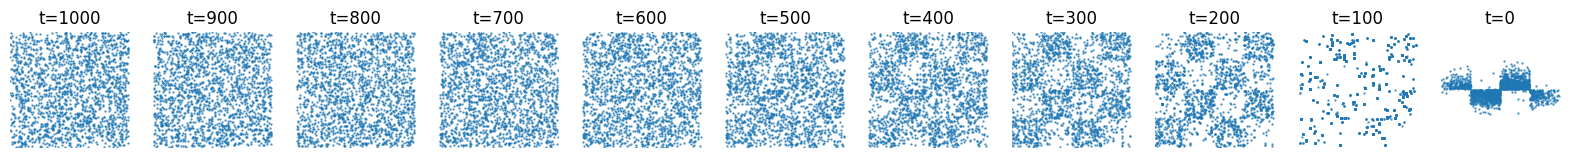

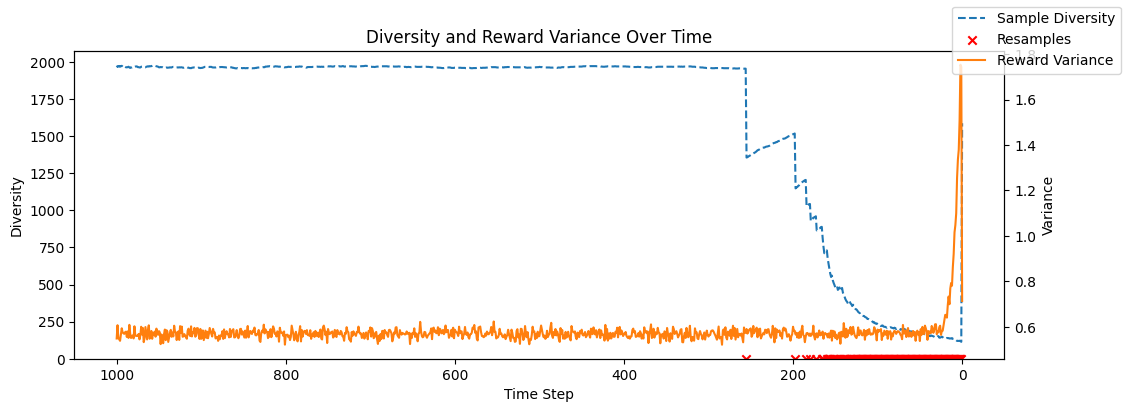

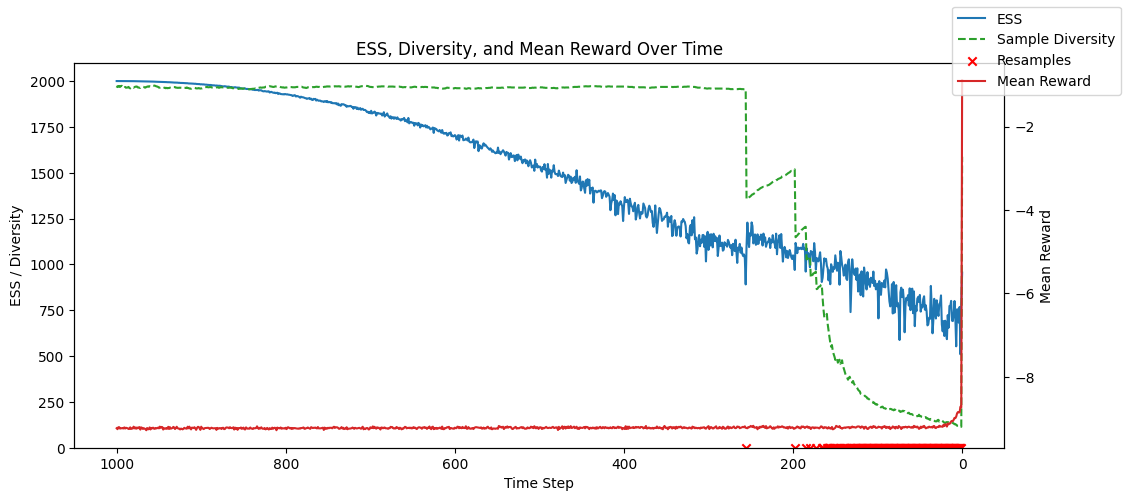

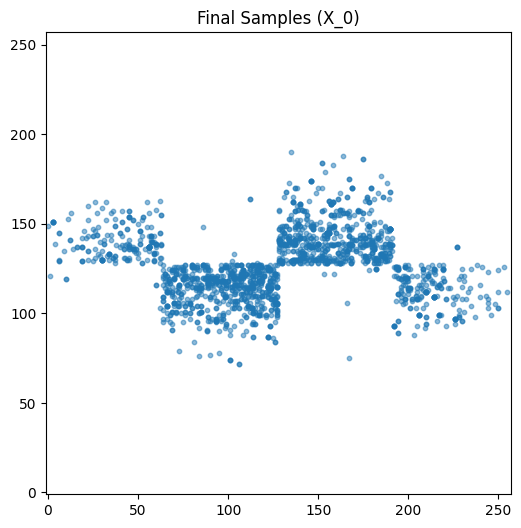

Final average reward: -0.9137
Final diversity: 1183


In [9]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

## Reverse diffusion as proposal

In [10]:
num_particles = 2000
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=reverse_as_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=100,
    device=device,
    verbose=False,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:37, 26.70it/s]

  1%|          | 6/1000 [00:00<00:37, 26.73it/s]

  1%|          | 9/1000 [00:00<00:37, 26.71it/s]

  1%|          | 12/1000 [00:00<00:37, 26.65it/s]

  2%|▏         | 15/1000 [00:00<00:36, 26.66it/s]

  2%|▏         | 18/1000 [00:00<00:36, 26.66it/s]

  2%|▏         | 21/1000 [00:00<00:36, 26.65it/s]

  2%|▏         | 24/1000 [00:00<00:36, 26.66it/s]

  3%|▎         | 27/1000 [00:01<00:36, 26.63it/s]

  3%|▎         | 30/1000 [00:01<00:36, 26.66it/s]

  3%|▎         | 33/1000 [00:01<00:36, 26.66it/s]

  4%|▎         | 36/1000 [00:01<00:36, 26.65it/s]

  4%|▍         | 39/1000 [00:01<00:36, 26.64it/s]

  4%|▍         | 42/1000 [00:01<00:35, 26.63it/s]

  4%|▍         | 45/1000 [00:01<00:35, 26.64it/s]

  5%|▍         | 48/1000 [00:01<00:35, 26.64it/s]

  5%|▌         | 51/1000 [00:01<00:35, 26.64it/s]

  5%|▌         | 54/1000 [00:02<00:35, 26.66it/s]

  6%|▌         | 57/1000 [00:02<00:35, 26.66it/s]

  6%|▌         | 60/1000 [00:02<00:35, 26.67it/s]

  6%|▋         | 63/1000 [00:02<00:35, 26.67it/s]

  7%|▋         | 66/1000 [00:02<00:35, 26.65it/s]

  7%|▋         | 69/1000 [00:02<00:34, 26.65it/s]

  7%|▋         | 72/1000 [00:02<00:34, 26.67it/s]

  8%|▊         | 75/1000 [00:02<00:34, 26.65it/s]

  8%|▊         | 78/1000 [00:02<00:34, 26.67it/s]

  8%|▊         | 81/1000 [00:03<00:34, 26.66it/s]

  8%|▊         | 84/1000 [00:03<00:34, 26.66it/s]

  9%|▊         | 87/1000 [00:03<00:34, 26.66it/s]

  9%|▉         | 90/1000 [00:03<00:34, 26.66it/s]

  9%|▉         | 93/1000 [00:03<00:34, 26.65it/s]

 10%|▉         | 96/1000 [00:03<00:33, 26.65it/s]

 10%|▉         | 99/1000 [00:03<00:33, 26.66it/s]

 10%|█         | 102/1000 [00:03<00:33, 26.65it/s]

 10%|█         | 105/1000 [00:03<00:33, 26.65it/s]

 11%|█         | 108/1000 [00:04<00:33, 26.65it/s]

 11%|█         | 111/1000 [00:04<00:33, 26.65it/s]

 11%|█▏        | 114/1000 [00:04<00:33, 26.64it/s]

 12%|█▏        | 117/1000 [00:04<00:33, 26.64it/s]

 12%|█▏        | 120/1000 [00:04<00:33, 26.64it/s]

 12%|█▏        | 123/1000 [00:04<00:32, 26.65it/s]

 13%|█▎        | 126/1000 [00:04<00:32, 26.65it/s]

 13%|█▎        | 129/1000 [00:04<00:32, 26.65it/s]

 13%|█▎        | 132/1000 [00:04<00:32, 26.65it/s]

 14%|█▎        | 135/1000 [00:05<00:32, 26.66it/s]

 14%|█▍        | 138/1000 [00:05<00:32, 26.66it/s]

 14%|█▍        | 141/1000 [00:05<00:32, 26.67it/s]

 14%|█▍        | 144/1000 [00:05<00:32, 26.64it/s]

 15%|█▍        | 147/1000 [00:05<00:32, 26.61it/s]

 15%|█▌        | 150/1000 [00:05<00:31, 26.60it/s]

 15%|█▌        | 153/1000 [00:05<00:31, 26.64it/s]

 16%|█▌        | 156/1000 [00:05<00:31, 26.66it/s]

 16%|█▌        | 159/1000 [00:05<00:31, 26.67it/s]

 16%|█▌        | 162/1000 [00:06<00:31, 26.68it/s]

 16%|█▋        | 165/1000 [00:06<00:31, 26.68it/s]

 17%|█▋        | 168/1000 [00:06<00:31, 26.68it/s]

 17%|█▋        | 171/1000 [00:06<00:31, 26.70it/s]

 17%|█▋        | 174/1000 [00:06<00:30, 26.68it/s]

 18%|█▊        | 177/1000 [00:06<00:30, 26.70it/s]

 18%|█▊        | 180/1000 [00:06<00:30, 26.68it/s]

 18%|█▊        | 183/1000 [00:06<00:30, 26.69it/s]

 19%|█▊        | 186/1000 [00:06<00:30, 26.69it/s]

 19%|█▉        | 189/1000 [00:07<00:30, 26.67it/s]

 19%|█▉        | 192/1000 [00:07<00:30, 26.68it/s]

 20%|█▉        | 195/1000 [00:07<00:30, 26.69it/s]

 20%|█▉        | 198/1000 [00:07<00:30, 26.70it/s]

 20%|██        | 201/1000 [00:07<00:29, 26.69it/s]

 20%|██        | 204/1000 [00:07<00:29, 26.68it/s]

 21%|██        | 207/1000 [00:07<00:29, 26.68it/s]

 21%|██        | 210/1000 [00:07<00:29, 26.68it/s]

 21%|██▏       | 213/1000 [00:07<00:29, 26.71it/s]

 22%|██▏       | 216/1000 [00:08<00:29, 26.70it/s]

 22%|██▏       | 219/1000 [00:08<00:29, 26.69it/s]

 22%|██▏       | 222/1000 [00:08<00:29, 26.68it/s]

 22%|██▎       | 225/1000 [00:08<00:29, 26.67it/s]

 23%|██▎       | 228/1000 [00:08<00:28, 26.67it/s]

 23%|██▎       | 231/1000 [00:08<00:28, 26.69it/s]

 23%|██▎       | 234/1000 [00:08<00:28, 26.70it/s]

 24%|██▎       | 237/1000 [00:08<00:28, 26.68it/s]

 24%|██▍       | 240/1000 [00:09<00:28, 26.68it/s]

 24%|██▍       | 243/1000 [00:09<00:28, 26.65it/s]

 25%|██▍       | 246/1000 [00:09<00:28, 26.64it/s]

 25%|██▍       | 249/1000 [00:09<00:28, 26.65it/s]

 25%|██▌       | 252/1000 [00:09<00:28, 26.66it/s]

 26%|██▌       | 255/1000 [00:09<00:27, 26.67it/s]

 26%|██▌       | 258/1000 [00:09<00:27, 26.68it/s]

 26%|██▌       | 261/1000 [00:09<00:27, 26.67it/s]

 26%|██▋       | 264/1000 [00:09<00:27, 26.67it/s]

 27%|██▋       | 267/1000 [00:10<00:27, 26.66it/s]

 27%|██▋       | 270/1000 [00:10<00:27, 26.67it/s]

 27%|██▋       | 273/1000 [00:10<00:27, 26.67it/s]

 28%|██▊       | 276/1000 [00:10<00:27, 26.67it/s]

 28%|██▊       | 279/1000 [00:10<00:27, 26.67it/s]

 28%|██▊       | 282/1000 [00:10<00:26, 26.67it/s]

 28%|██▊       | 285/1000 [00:10<00:26, 26.64it/s]

 29%|██▉       | 288/1000 [00:10<00:26, 26.64it/s]

 29%|██▉       | 291/1000 [00:10<00:26, 26.61it/s]

 29%|██▉       | 294/1000 [00:11<00:26, 26.49it/s]

 30%|██▉       | 297/1000 [00:11<00:26, 26.46it/s]

 30%|███       | 300/1000 [00:11<00:26, 26.49it/s]

 30%|███       | 303/1000 [00:11<00:26, 26.55it/s]

 31%|███       | 306/1000 [00:11<00:26, 26.57it/s]

 31%|███       | 309/1000 [00:11<00:26, 26.56it/s]

 31%|███       | 312/1000 [00:11<00:25, 26.56it/s]

 32%|███▏      | 315/1000 [00:11<00:25, 26.57it/s]

 32%|███▏      | 318/1000 [00:11<00:25, 26.60it/s]

 32%|███▏      | 321/1000 [00:12<00:25, 26.58it/s]

 32%|███▏      | 324/1000 [00:12<00:25, 26.47it/s]

 33%|███▎      | 327/1000 [00:12<00:25, 26.54it/s]

 33%|███▎      | 330/1000 [00:12<00:25, 26.56it/s]

 33%|███▎      | 333/1000 [00:12<00:25, 26.60it/s]

 34%|███▎      | 336/1000 [00:12<00:24, 26.62it/s]

 34%|███▍      | 339/1000 [00:12<00:24, 26.63it/s]

 34%|███▍      | 342/1000 [00:12<00:24, 26.64it/s]

 34%|███▍      | 345/1000 [00:12<00:24, 26.65it/s]

 35%|███▍      | 348/1000 [00:13<00:24, 26.65it/s]

 35%|███▌      | 351/1000 [00:13<00:24, 26.64it/s]

 35%|███▌      | 354/1000 [00:13<00:24, 26.65it/s]

 36%|███▌      | 357/1000 [00:13<00:24, 26.64it/s]

 36%|███▌      | 360/1000 [00:13<00:23, 26.67it/s]

 36%|███▋      | 363/1000 [00:13<00:23, 26.64it/s]

 37%|███▋      | 366/1000 [00:13<00:23, 26.63it/s]

 37%|███▋      | 369/1000 [00:13<00:23, 26.64it/s]

 37%|███▋      | 372/1000 [00:13<00:23, 26.65it/s]

 38%|███▊      | 375/1000 [00:14<00:23, 26.65it/s]

 38%|███▊      | 378/1000 [00:14<00:23, 26.64it/s]

 38%|███▊      | 381/1000 [00:14<00:23, 26.52it/s]

 38%|███▊      | 384/1000 [00:14<00:23, 26.54it/s]

 39%|███▊      | 387/1000 [00:14<00:23, 26.57it/s]

 39%|███▉      | 390/1000 [00:14<00:22, 26.60it/s]

 39%|███▉      | 393/1000 [00:14<00:22, 26.60it/s]

 40%|███▉      | 396/1000 [00:14<00:22, 26.63it/s]

 40%|███▉      | 399/1000 [00:14<00:22, 26.63it/s]

 40%|████      | 402/1000 [00:15<00:22, 26.63it/s]

 40%|████      | 405/1000 [00:15<00:22, 26.64it/s]

 41%|████      | 408/1000 [00:15<00:22, 26.63it/s]

 41%|████      | 411/1000 [00:15<00:22, 26.64it/s]

 41%|████▏     | 414/1000 [00:15<00:22, 26.62it/s]

 42%|████▏     | 417/1000 [00:15<00:21, 26.63it/s]

 42%|████▏     | 420/1000 [00:15<00:21, 26.64it/s]

 42%|████▏     | 423/1000 [00:15<00:21, 26.55it/s]

 43%|████▎     | 426/1000 [00:15<00:21, 26.57it/s]

 43%|████▎     | 429/1000 [00:16<00:21, 26.57it/s]

 43%|████▎     | 432/1000 [00:16<00:21, 26.60it/s]

 44%|████▎     | 435/1000 [00:16<00:21, 26.61it/s]

 44%|████▍     | 438/1000 [00:16<00:21, 26.62it/s]

 44%|████▍     | 441/1000 [00:16<00:20, 26.63it/s]

 44%|████▍     | 444/1000 [00:16<00:20, 26.63it/s]

 45%|████▍     | 447/1000 [00:16<00:20, 26.63it/s]

 45%|████▌     | 450/1000 [00:16<00:20, 26.64it/s]

 45%|████▌     | 453/1000 [00:17<00:20, 26.64it/s]

 46%|████▌     | 456/1000 [00:17<00:20, 26.65it/s]

 46%|████▌     | 459/1000 [00:17<00:20, 26.63it/s]

 46%|████▌     | 462/1000 [00:17<00:20, 26.62it/s]

 46%|████▋     | 465/1000 [00:17<00:20, 26.63it/s]

 47%|████▋     | 468/1000 [00:17<00:19, 26.62it/s]

 47%|████▋     | 471/1000 [00:17<00:19, 26.61it/s]

 47%|████▋     | 474/1000 [00:17<00:19, 26.60it/s]

 48%|████▊     | 477/1000 [00:17<00:19, 26.59it/s]

 48%|████▊     | 480/1000 [00:18<00:19, 26.60it/s]

 48%|████▊     | 483/1000 [00:18<00:19, 26.61it/s]

 49%|████▊     | 486/1000 [00:18<00:19, 26.53it/s]

 49%|████▉     | 489/1000 [00:18<00:19, 26.56it/s]

 49%|████▉     | 492/1000 [00:18<00:19, 26.56it/s]

 50%|████▉     | 495/1000 [00:18<00:19, 26.56it/s]

 50%|████▉     | 498/1000 [00:18<00:18, 26.50it/s]

 50%|█████     | 501/1000 [00:18<00:18, 26.53it/s]

 50%|█████     | 504/1000 [00:18<00:18, 26.54it/s]

 51%|█████     | 507/1000 [00:19<00:18, 26.50it/s]

 51%|█████     | 510/1000 [00:19<00:18, 26.51it/s]

 51%|█████▏    | 513/1000 [00:19<00:18, 26.54it/s]

 52%|█████▏    | 516/1000 [00:19<00:18, 26.54it/s]

 52%|█████▏    | 519/1000 [00:19<00:18, 26.49it/s]

 52%|█████▏    | 522/1000 [00:19<00:18, 26.49it/s]

 52%|█████▎    | 525/1000 [00:19<00:17, 26.51it/s]

 53%|█████▎    | 528/1000 [00:19<00:17, 26.54it/s]

 53%|█████▎    | 531/1000 [00:19<00:17, 26.55it/s]

 53%|█████▎    | 534/1000 [00:20<00:17, 26.55it/s]

 54%|█████▎    | 537/1000 [00:20<00:17, 26.54it/s]

 54%|█████▍    | 540/1000 [00:20<00:17, 26.53it/s]

 54%|█████▍    | 543/1000 [00:20<00:17, 26.53it/s]

 55%|█████▍    | 546/1000 [00:20<00:17, 26.53it/s]

 55%|█████▍    | 549/1000 [00:20<00:17, 26.53it/s]

 55%|█████▌    | 552/1000 [00:20<00:16, 26.55it/s]

 56%|█████▌    | 555/1000 [00:20<00:16, 26.57it/s]

 56%|█████▌    | 558/1000 [00:20<00:16, 26.57it/s]

 56%|█████▌    | 561/1000 [00:21<00:16, 26.59it/s]

 56%|█████▋    | 564/1000 [00:21<00:16, 26.60it/s]

 57%|█████▋    | 567/1000 [00:21<00:16, 26.57it/s]

 57%|█████▋    | 570/1000 [00:21<00:16, 26.57it/s]

 57%|█████▋    | 573/1000 [00:21<00:16, 26.57it/s]

 58%|█████▊    | 576/1000 [00:21<00:15, 26.57it/s]

 58%|█████▊    | 579/1000 [00:21<00:15, 26.54it/s]

 58%|█████▊    | 582/1000 [00:21<00:15, 26.57it/s]

 58%|█████▊    | 585/1000 [00:21<00:15, 26.59it/s]

 59%|█████▉    | 588/1000 [00:22<00:15, 26.63it/s]

 59%|█████▉    | 591/1000 [00:22<00:15, 26.63it/s]

 59%|█████▉    | 594/1000 [00:22<00:15, 26.64it/s]

 60%|█████▉    | 597/1000 [00:22<00:15, 26.63it/s]

 60%|██████    | 600/1000 [00:22<00:15, 26.63it/s]

 60%|██████    | 603/1000 [00:22<00:14, 26.63it/s]

 61%|██████    | 606/1000 [00:22<00:14, 26.63it/s]

 61%|██████    | 609/1000 [00:22<00:14, 26.65it/s]

 61%|██████    | 612/1000 [00:22<00:14, 26.64it/s]

 62%|██████▏   | 615/1000 [00:23<00:14, 26.64it/s]

 62%|██████▏   | 618/1000 [00:23<00:14, 26.64it/s]

 62%|██████▏   | 621/1000 [00:23<00:14, 26.63it/s]

 62%|██████▏   | 624/1000 [00:23<00:14, 26.63it/s]

 63%|██████▎   | 627/1000 [00:23<00:14, 26.64it/s]

 63%|██████▎   | 630/1000 [00:23<00:13, 26.63it/s]

 63%|██████▎   | 633/1000 [00:23<00:13, 26.64it/s]

 64%|██████▎   | 636/1000 [00:23<00:13, 26.64it/s]

 64%|██████▍   | 639/1000 [00:24<00:13, 26.63it/s]

 64%|██████▍   | 642/1000 [00:24<00:13, 26.64it/s]

 64%|██████▍   | 645/1000 [00:24<00:13, 26.64it/s]

 65%|██████▍   | 648/1000 [00:24<00:13, 26.62it/s]

 65%|██████▌   | 651/1000 [00:24<00:13, 26.63it/s]

 65%|██████▌   | 654/1000 [00:24<00:13, 26.61it/s]

 66%|██████▌   | 657/1000 [00:24<00:12, 26.61it/s]

 66%|██████▌   | 660/1000 [00:24<00:12, 26.61it/s]

 66%|██████▋   | 663/1000 [00:24<00:12, 26.61it/s]

 67%|██████▋   | 666/1000 [00:25<00:12, 26.62it/s]

 67%|██████▋   | 669/1000 [00:25<00:12, 26.62it/s]

 67%|██████▋   | 672/1000 [00:25<00:12, 26.62it/s]

 68%|██████▊   | 675/1000 [00:25<00:12, 26.62it/s]

 68%|██████▊   | 678/1000 [00:25<00:12, 26.62it/s]

 68%|██████▊   | 681/1000 [00:25<00:11, 26.61it/s]

 68%|██████▊   | 684/1000 [00:25<00:11, 26.62it/s]

 69%|██████▊   | 687/1000 [00:25<00:11, 26.60it/s]

 69%|██████▉   | 690/1000 [00:25<00:11, 26.59it/s]

 69%|██████▉   | 693/1000 [00:26<00:11, 26.55it/s]

 70%|██████▉   | 696/1000 [00:26<00:11, 26.55it/s]

 70%|██████▉   | 699/1000 [00:26<00:11, 26.57it/s]

 70%|███████   | 702/1000 [00:26<00:11, 26.59it/s]

 70%|███████   | 705/1000 [00:26<00:11, 26.61it/s]

 71%|███████   | 708/1000 [00:26<00:10, 26.62it/s]

 71%|███████   | 711/1000 [00:26<00:10, 26.62it/s]

 71%|███████▏  | 714/1000 [00:26<00:10, 26.62it/s]

 72%|███████▏  | 717/1000 [00:26<00:10, 26.54it/s]

 72%|███████▏  | 720/1000 [00:27<00:10, 26.57it/s]

 72%|███████▏  | 723/1000 [00:27<00:10, 26.59it/s]

 73%|███████▎  | 726/1000 [00:27<00:10, 26.59it/s]

 73%|███████▎  | 729/1000 [00:27<00:10, 26.61it/s]

 73%|███████▎  | 732/1000 [00:27<00:10, 26.62it/s]

 74%|███████▎  | 735/1000 [00:27<00:09, 26.62it/s]

 74%|███████▍  | 738/1000 [00:27<00:09, 26.60it/s]

 74%|███████▍  | 741/1000 [00:27<00:09, 26.63it/s]

 74%|███████▍  | 744/1000 [00:27<00:09, 26.64it/s]

 75%|███████▍  | 747/1000 [00:28<00:09, 26.63it/s]

 75%|███████▌  | 750/1000 [00:28<00:09, 26.63it/s]

 75%|███████▌  | 753/1000 [00:28<00:09, 26.63it/s]

 76%|███████▌  | 756/1000 [00:28<00:09, 26.63it/s]

 76%|███████▌  | 759/1000 [00:28<00:09, 26.64it/s]

 76%|███████▌  | 762/1000 [00:28<00:08, 26.62it/s]

 76%|███████▋  | 765/1000 [00:28<00:08, 26.62it/s]

 77%|███████▋  | 768/1000 [00:28<00:08, 26.63it/s]

 77%|███████▋  | 771/1000 [00:28<00:08, 26.63it/s]

 77%|███████▋  | 774/1000 [00:29<00:08, 26.60it/s]

 78%|███████▊  | 777/1000 [00:29<00:08, 26.60it/s]

 78%|███████▊  | 780/1000 [00:29<00:08, 26.60it/s]

 78%|███████▊  | 783/1000 [00:29<00:08, 26.62it/s]

 79%|███████▊  | 786/1000 [00:29<00:08, 26.61it/s]

 79%|███████▉  | 789/1000 [00:29<00:07, 26.60it/s]

 79%|███████▉  | 792/1000 [00:29<00:07, 26.61it/s]

 80%|███████▉  | 795/1000 [00:29<00:07, 26.61it/s]

 80%|███████▉  | 798/1000 [00:29<00:07, 26.61it/s]

 80%|████████  | 801/1000 [00:30<00:07, 26.62it/s]

 80%|████████  | 804/1000 [00:30<00:07, 26.62it/s]

 81%|████████  | 807/1000 [00:30<00:07, 26.62it/s]

 81%|████████  | 810/1000 [00:30<00:07, 26.62it/s]

 81%|████████▏ | 813/1000 [00:30<00:07, 26.63it/s]

 82%|████████▏ | 816/1000 [00:30<00:06, 26.62it/s]

 82%|████████▏ | 819/1000 [00:30<00:06, 26.62it/s]

 82%|████████▏ | 822/1000 [00:30<00:06, 26.62it/s]

 82%|████████▎ | 825/1000 [00:30<00:06, 26.62it/s]

 83%|████████▎ | 828/1000 [00:31<00:06, 26.61it/s]

 83%|████████▎ | 831/1000 [00:31<00:06, 26.59it/s]

 83%|████████▎ | 834/1000 [00:31<00:06, 26.59it/s]

 84%|████████▎ | 837/1000 [00:31<00:06, 26.60it/s]

 84%|████████▍ | 840/1000 [00:31<00:06, 26.59it/s]

 84%|████████▍ | 843/1000 [00:31<00:05, 26.59it/s]

 85%|████████▍ | 846/1000 [00:31<00:05, 26.58it/s]

 85%|████████▍ | 849/1000 [00:31<00:05, 26.59it/s]

 85%|████████▌ | 852/1000 [00:32<00:05, 26.59it/s]

 86%|████████▌ | 855/1000 [00:32<00:05, 26.62it/s]

 86%|████████▌ | 858/1000 [00:32<00:05, 26.62it/s]

 86%|████████▌ | 861/1000 [00:32<00:05, 26.61it/s]

 86%|████████▋ | 864/1000 [00:32<00:05, 26.59it/s]

 87%|████████▋ | 867/1000 [00:32<00:05, 26.57it/s]

 87%|████████▋ | 870/1000 [00:32<00:04, 26.56it/s]

 87%|████████▋ | 873/1000 [00:32<00:04, 26.56it/s]

 88%|████████▊ | 876/1000 [00:32<00:04, 26.59it/s]

 88%|████████▊ | 879/1000 [00:33<00:04, 26.60it/s]

 88%|████████▊ | 882/1000 [00:33<00:04, 26.60it/s]

 88%|████████▊ | 885/1000 [00:33<00:04, 26.60it/s]

 89%|████████▉ | 888/1000 [00:33<00:04, 26.61it/s]

 89%|████████▉ | 891/1000 [00:33<00:04, 26.61it/s]

 89%|████████▉ | 894/1000 [00:33<00:03, 26.60it/s]

 90%|████████▉ | 897/1000 [00:33<00:03, 26.62it/s]

 90%|█████████ | 900/1000 [00:33<00:03, 26.62it/s]

 90%|█████████ | 903/1000 [00:33<00:03, 26.62it/s]

 91%|█████████ | 906/1000 [00:34<00:03, 26.62it/s]

 91%|█████████ | 909/1000 [00:34<00:03, 26.62it/s]

 91%|█████████ | 912/1000 [00:34<00:03, 26.64it/s]

 92%|█████████▏| 915/1000 [00:34<00:03, 26.64it/s]

 92%|█████████▏| 918/1000 [00:34<00:03, 26.63it/s]

 92%|█████████▏| 921/1000 [00:34<00:02, 26.62it/s]

 92%|█████████▏| 924/1000 [00:34<00:02, 26.63it/s]

 93%|█████████▎| 927/1000 [00:34<00:02, 26.62it/s]

 93%|█████████▎| 930/1000 [00:34<00:02, 26.62it/s]

 93%|█████████▎| 933/1000 [00:35<00:02, 26.61it/s]

 94%|█████████▎| 936/1000 [00:35<00:02, 26.61it/s]

 94%|█████████▍| 939/1000 [00:35<00:02, 26.59it/s]

 94%|█████████▍| 942/1000 [00:35<00:02, 26.59it/s]

 94%|█████████▍| 945/1000 [00:35<00:02, 26.56it/s]

 95%|█████████▍| 948/1000 [00:35<00:01, 26.56it/s]

 95%|█████████▌| 951/1000 [00:35<00:01, 26.54it/s]

 95%|█████████▌| 954/1000 [00:35<00:01, 26.56it/s]

 96%|█████████▌| 957/1000 [00:35<00:01, 26.56it/s]

 96%|█████████▌| 960/1000 [00:36<00:01, 26.54it/s]

 96%|█████████▋| 963/1000 [00:36<00:01, 26.53it/s]

 97%|█████████▋| 966/1000 [00:36<00:01, 26.46it/s]

 97%|█████████▋| 969/1000 [00:36<00:01, 26.45it/s]

 97%|█████████▋| 972/1000 [00:36<00:01, 26.44it/s]

 98%|█████████▊| 975/1000 [00:36<00:00, 26.42it/s]

 98%|█████████▊| 978/1000 [00:36<00:00, 26.40it/s]

 98%|█████████▊| 981/1000 [00:36<00:00, 26.39it/s]

 98%|█████████▊| 984/1000 [00:36<00:00, 26.39it/s]

 99%|█████████▊| 987/1000 [00:37<00:00, 26.39it/s]

 99%|█████████▉| 990/1000 [00:37<00:00, 26.38it/s]

 99%|█████████▉| 993/1000 [00:37<00:00, 26.39it/s]

100%|█████████▉| 996/1000 [00:37<00:00, 26.40it/s]

100%|█████████▉| 999/1000 [00:37<00:00, 26.42it/s]

100%|██████████| 1000/1000 [00:37<00:00, 26.61it/s]

Resampled 38 times.


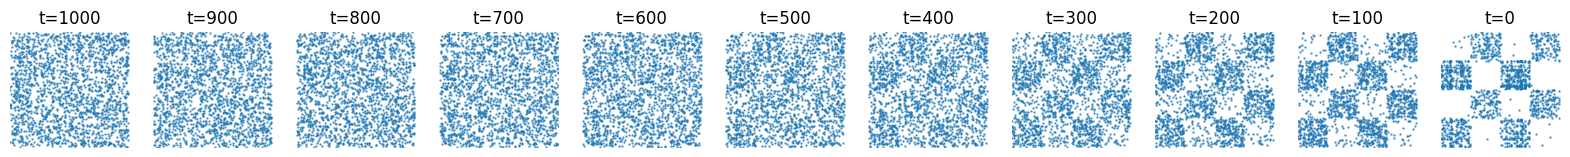

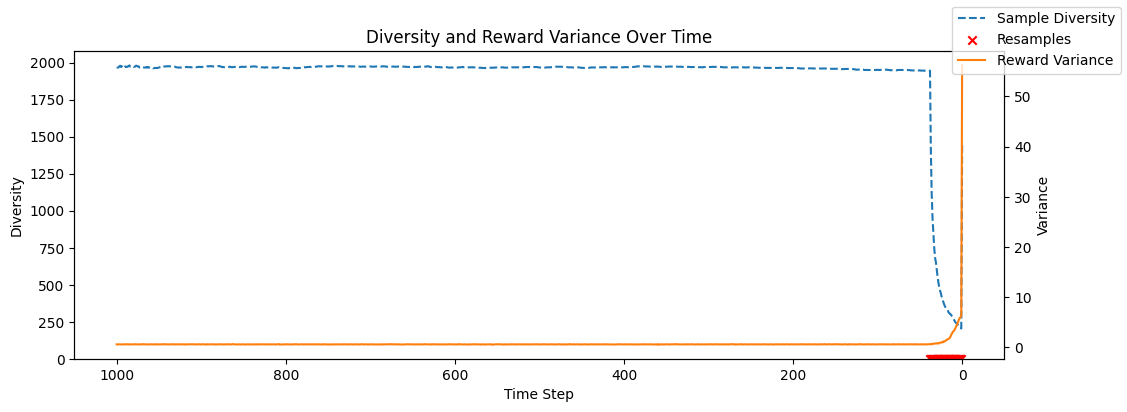

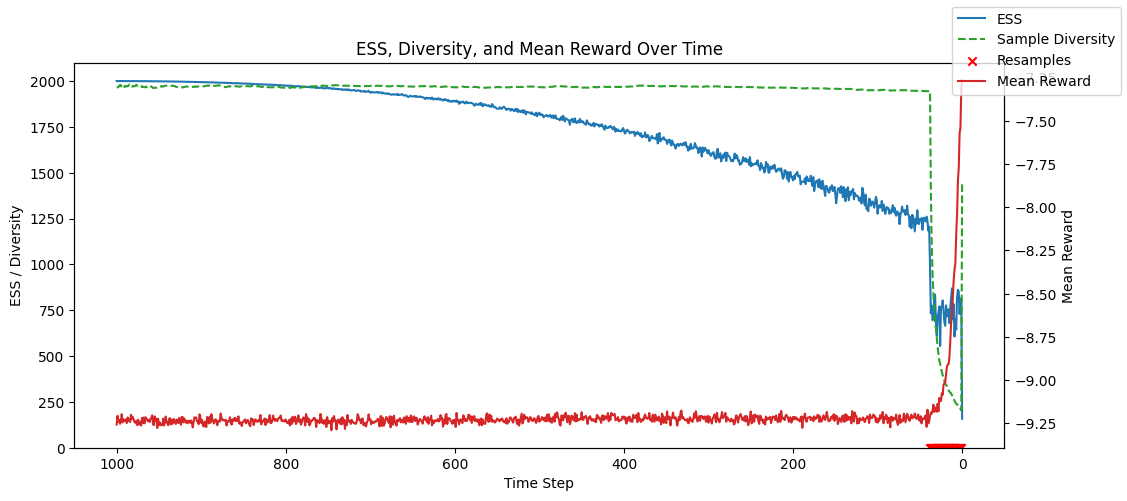

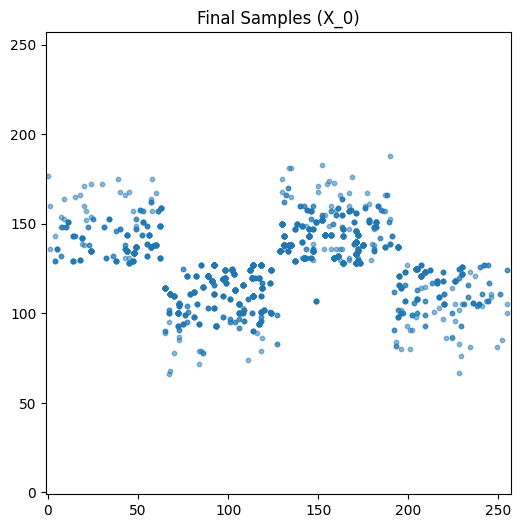

Final average reward: -0.9945
Final diversity: 396


In [11]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

## First order approximate proposal

In [12]:
num_particles = 2000
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=100,
    device=device,
    verbose=False,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:37, 26.61it/s]

  1%|          | 6/1000 [00:00<00:37, 26.58it/s]

  1%|          | 9/1000 [00:00<00:37, 26.56it/s]

  1%|          | 12/1000 [00:00<00:37, 26.55it/s]

  2%|▏         | 15/1000 [00:00<00:37, 26.54it/s]

  2%|▏         | 18/1000 [00:00<00:36, 26.55it/s]

  2%|▏         | 21/1000 [00:00<00:36, 26.54it/s]

  2%|▏         | 24/1000 [00:00<00:36, 26.53it/s]

  3%|▎         | 27/1000 [00:01<00:36, 26.55it/s]

  3%|▎         | 30/1000 [00:01<00:36, 26.59it/s]

  3%|▎         | 33/1000 [00:01<00:36, 26.61it/s]

  4%|▎         | 36/1000 [00:01<00:36, 26.60it/s]

  4%|▍         | 39/1000 [00:01<00:36, 26.59it/s]

  4%|▍         | 42/1000 [00:01<00:36, 26.60it/s]

  4%|▍         | 45/1000 [00:01<00:35, 26.59it/s]

  5%|▍         | 48/1000 [00:01<00:35, 26.59it/s]

  5%|▌         | 51/1000 [00:01<00:35, 26.57it/s]

  5%|▌         | 54/1000 [00:02<00:35, 26.59it/s]

  6%|▌         | 57/1000 [00:02<00:35, 26.58it/s]

  6%|▌         | 60/1000 [00:02<00:35, 26.59it/s]

  6%|▋         | 63/1000 [00:02<00:35, 26.58it/s]

  7%|▋         | 66/1000 [00:02<00:35, 26.58it/s]

  7%|▋         | 69/1000 [00:02<00:35, 26.59it/s]

  7%|▋         | 72/1000 [00:02<00:34, 26.59it/s]

  8%|▊         | 75/1000 [00:02<00:34, 26.57it/s]

  8%|▊         | 78/1000 [00:02<00:34, 26.60it/s]

  8%|▊         | 81/1000 [00:03<00:34, 26.56it/s]

  8%|▊         | 84/1000 [00:03<00:34, 26.57it/s]

  9%|▊         | 87/1000 [00:03<00:34, 26.56it/s]

  9%|▉         | 90/1000 [00:03<00:34, 26.56it/s]

  9%|▉         | 93/1000 [00:03<00:34, 26.56it/s]

 10%|▉         | 96/1000 [00:03<00:34, 26.57it/s]

 10%|▉         | 99/1000 [00:03<00:33, 26.57it/s]

 10%|█         | 102/1000 [00:03<00:33, 26.59it/s]

 10%|█         | 105/1000 [00:03<00:33, 26.59it/s]

 11%|█         | 108/1000 [00:04<00:33, 26.59it/s]

 11%|█         | 111/1000 [00:04<00:33, 26.58it/s]

 11%|█▏        | 114/1000 [00:04<00:33, 26.57it/s]

 12%|█▏        | 117/1000 [00:04<00:33, 26.57it/s]

 12%|█▏        | 120/1000 [00:04<00:33, 26.54it/s]

 12%|█▏        | 123/1000 [00:04<00:33, 26.54it/s]

 13%|█▎        | 126/1000 [00:04<00:32, 26.55it/s]

 13%|█▎        | 129/1000 [00:04<00:32, 26.56it/s]

 13%|█▎        | 132/1000 [00:04<00:32, 26.57it/s]

 14%|█▎        | 135/1000 [00:05<00:32, 26.54it/s]

 14%|█▍        | 138/1000 [00:05<00:32, 26.55it/s]

 14%|█▍        | 141/1000 [00:05<00:32, 26.55it/s]

 14%|█▍        | 144/1000 [00:05<00:32, 26.54it/s]

 15%|█▍        | 147/1000 [00:05<00:32, 26.55it/s]

 15%|█▌        | 150/1000 [00:05<00:32, 26.56it/s]

 15%|█▌        | 153/1000 [00:05<00:31, 26.56it/s]

 16%|█▌        | 156/1000 [00:05<00:31, 26.56it/s]

 16%|█▌        | 159/1000 [00:05<00:31, 26.55it/s]

 16%|█▌        | 162/1000 [00:06<00:31, 26.54it/s]

 16%|█▋        | 165/1000 [00:06<00:31, 26.56it/s]

 17%|█▋        | 168/1000 [00:06<00:31, 26.55it/s]

 17%|█▋        | 171/1000 [00:06<00:31, 26.56it/s]

 17%|█▋        | 174/1000 [00:06<00:31, 26.56it/s]

 18%|█▊        | 177/1000 [00:06<00:30, 26.57it/s]

 18%|█▊        | 180/1000 [00:06<00:30, 26.57it/s]

 18%|█▊        | 183/1000 [00:06<00:30, 26.56it/s]

 19%|█▊        | 186/1000 [00:07<00:30, 26.56it/s]

 19%|█▉        | 189/1000 [00:07<00:30, 26.56it/s]

 19%|█▉        | 192/1000 [00:07<00:30, 26.60it/s]

 20%|█▉        | 195/1000 [00:07<00:30, 26.59it/s]

 20%|█▉        | 198/1000 [00:07<00:30, 26.60it/s]

 20%|██        | 201/1000 [00:07<00:30, 26.60it/s]

 20%|██        | 204/1000 [00:07<00:29, 26.58it/s]

 21%|██        | 207/1000 [00:07<00:29, 26.58it/s]

 21%|██        | 210/1000 [00:07<00:29, 26.58it/s]

 21%|██▏       | 213/1000 [00:08<00:29, 26.59it/s]

 22%|██▏       | 216/1000 [00:08<00:29, 26.60it/s]

 22%|██▏       | 219/1000 [00:08<00:29, 26.62it/s]

 22%|██▏       | 222/1000 [00:08<00:29, 26.60it/s]

 22%|██▎       | 225/1000 [00:08<00:29, 26.62it/s]

 23%|██▎       | 228/1000 [00:08<00:29, 26.61it/s]

 23%|██▎       | 231/1000 [00:08<00:28, 26.58it/s]

 23%|██▎       | 234/1000 [00:08<00:28, 26.57it/s]

 24%|██▎       | 237/1000 [00:08<00:28, 26.58it/s]

 24%|██▍       | 240/1000 [00:09<00:28, 26.58it/s]

 24%|██▍       | 243/1000 [00:09<00:28, 26.58it/s]

 25%|██▍       | 246/1000 [00:09<00:28, 26.58it/s]

 25%|██▍       | 249/1000 [00:09<00:28, 26.59it/s]

 25%|██▌       | 252/1000 [00:09<00:28, 26.59it/s]

 26%|██▌       | 255/1000 [00:09<00:28, 26.58it/s]

 26%|██▌       | 258/1000 [00:09<00:27, 26.59it/s]

 26%|██▌       | 261/1000 [00:09<00:27, 26.60it/s]

 26%|██▋       | 264/1000 [00:09<00:27, 26.60it/s]

 27%|██▋       | 267/1000 [00:10<00:27, 26.60it/s]

 27%|██▋       | 270/1000 [00:10<00:27, 26.58it/s]

 27%|██▋       | 273/1000 [00:10<00:27, 26.56it/s]

 28%|██▊       | 276/1000 [00:10<00:27, 26.57it/s]

 28%|██▊       | 279/1000 [00:10<00:27, 26.57it/s]

 28%|██▊       | 282/1000 [00:10<00:27, 26.57it/s]

 28%|██▊       | 285/1000 [00:10<00:26, 26.56it/s]

 29%|██▉       | 288/1000 [00:10<00:26, 26.55it/s]

 29%|██▉       | 291/1000 [00:10<00:26, 26.56it/s]

 29%|██▉       | 294/1000 [00:11<00:26, 26.56it/s]

 30%|██▉       | 297/1000 [00:11<00:26, 26.56it/s]

 30%|███       | 300/1000 [00:11<00:26, 26.58it/s]

 30%|███       | 303/1000 [00:11<00:26, 26.57it/s]

 31%|███       | 306/1000 [00:11<00:26, 26.58it/s]

 31%|███       | 309/1000 [00:11<00:25, 26.59it/s]

 31%|███       | 312/1000 [00:11<00:25, 26.59it/s]

 32%|███▏      | 315/1000 [00:11<00:25, 26.58it/s]

 32%|███▏      | 318/1000 [00:11<00:25, 26.59it/s]

 32%|███▏      | 321/1000 [00:12<00:25, 26.60it/s]

 32%|███▏      | 324/1000 [00:12<00:25, 26.58it/s]

 33%|███▎      | 327/1000 [00:12<00:25, 26.58it/s]

 33%|███▎      | 330/1000 [00:12<00:25, 26.58it/s]

 33%|███▎      | 333/1000 [00:12<00:25, 26.58it/s]

 34%|███▎      | 336/1000 [00:12<00:24, 26.58it/s]

 34%|███▍      | 339/1000 [00:12<00:24, 26.60it/s]

 34%|███▍      | 342/1000 [00:12<00:24, 26.61it/s]

 34%|███▍      | 345/1000 [00:12<00:24, 26.61it/s]

 35%|███▍      | 348/1000 [00:13<00:24, 26.59it/s]

 35%|███▌      | 351/1000 [00:13<00:24, 26.61it/s]

 35%|███▌      | 354/1000 [00:13<00:24, 26.60it/s]

 36%|███▌      | 357/1000 [00:13<00:24, 26.58it/s]

 36%|███▌      | 360/1000 [00:13<00:24, 26.58it/s]

 36%|███▋      | 363/1000 [00:13<00:23, 26.59it/s]

 37%|███▋      | 366/1000 [00:13<00:23, 26.59it/s]

 37%|███▋      | 369/1000 [00:13<00:23, 26.59it/s]

 37%|███▋      | 372/1000 [00:13<00:23, 26.58it/s]

 38%|███▊      | 375/1000 [00:14<00:23, 26.57it/s]

 38%|███▊      | 378/1000 [00:14<00:23, 26.57it/s]

 38%|███▊      | 381/1000 [00:14<00:23, 26.57it/s]

 38%|███▊      | 384/1000 [00:14<00:23, 26.57it/s]

 39%|███▊      | 387/1000 [00:14<00:23, 26.57it/s]

 39%|███▉      | 390/1000 [00:14<00:22, 26.57it/s]

 39%|███▉      | 393/1000 [00:14<00:22, 26.57it/s]

 40%|███▉      | 396/1000 [00:14<00:22, 26.57it/s]

 40%|███▉      | 399/1000 [00:15<00:22, 26.57it/s]

 40%|████      | 402/1000 [00:15<00:22, 26.56it/s]

 40%|████      | 405/1000 [00:15<00:22, 26.57it/s]

 41%|████      | 408/1000 [00:15<00:22, 26.59it/s]

 41%|████      | 411/1000 [00:15<00:22, 26.59it/s]

 41%|████▏     | 414/1000 [00:15<00:22, 26.59it/s]

 42%|████▏     | 417/1000 [00:15<00:21, 26.58it/s]

 42%|████▏     | 420/1000 [00:15<00:21, 26.58it/s]

 42%|████▏     | 423/1000 [00:15<00:21, 26.58it/s]

 43%|████▎     | 426/1000 [00:16<00:21, 26.59it/s]

 43%|████▎     | 429/1000 [00:16<00:21, 26.61it/s]

 43%|████▎     | 432/1000 [00:16<00:21, 26.59it/s]

 44%|████▎     | 435/1000 [00:16<00:21, 26.60it/s]

 44%|████▍     | 438/1000 [00:16<00:21, 26.60it/s]

 44%|████▍     | 441/1000 [00:16<00:21, 26.60it/s]

 44%|████▍     | 444/1000 [00:16<00:20, 26.59it/s]

 45%|████▍     | 447/1000 [00:16<00:20, 26.60it/s]

 45%|████▌     | 450/1000 [00:16<00:20, 26.61it/s]

 45%|████▌     | 453/1000 [00:17<00:20, 26.60it/s]

 46%|████▌     | 456/1000 [00:17<00:20, 26.59it/s]

 46%|████▌     | 459/1000 [00:17<00:20, 26.58it/s]

 46%|████▌     | 462/1000 [00:17<00:20, 26.57it/s]

 46%|████▋     | 465/1000 [00:17<00:20, 26.57it/s]

 47%|████▋     | 468/1000 [00:17<00:19, 26.61it/s]

 47%|████▋     | 471/1000 [00:17<00:19, 26.63it/s]

 47%|████▋     | 474/1000 [00:17<00:19, 26.61it/s]

 48%|████▊     | 477/1000 [00:17<00:19, 26.61it/s]

 48%|████▊     | 480/1000 [00:18<00:19, 26.60it/s]

 48%|████▊     | 483/1000 [00:18<00:19, 26.60it/s]

 49%|████▊     | 486/1000 [00:18<00:19, 26.56it/s]

 49%|████▉     | 489/1000 [00:18<00:19, 26.55it/s]

 49%|████▉     | 492/1000 [00:18<00:19, 26.57it/s]

 50%|████▉     | 495/1000 [00:18<00:19, 26.57it/s]

 50%|████▉     | 498/1000 [00:18<00:18, 26.57it/s]

 50%|█████     | 501/1000 [00:18<00:18, 26.55it/s]

 50%|█████     | 504/1000 [00:18<00:18, 26.56it/s]

 51%|█████     | 507/1000 [00:19<00:18, 26.55it/s]

 51%|█████     | 510/1000 [00:19<00:18, 26.56it/s]

 51%|█████▏    | 513/1000 [00:19<00:18, 26.57it/s]

 52%|█████▏    | 516/1000 [00:19<00:18, 26.56it/s]

 52%|█████▏    | 519/1000 [00:19<00:18, 26.57it/s]

 52%|█████▏    | 522/1000 [00:19<00:17, 26.60it/s]

 52%|█████▎    | 525/1000 [00:19<00:17, 26.60it/s]

 53%|█████▎    | 528/1000 [00:19<00:17, 26.60it/s]

 53%|█████▎    | 531/1000 [00:19<00:17, 26.57it/s]

 53%|█████▎    | 534/1000 [00:20<00:17, 26.56it/s]

 54%|█████▎    | 537/1000 [00:20<00:17, 26.56it/s]

 54%|█████▍    | 540/1000 [00:20<00:17, 26.56it/s]

 54%|█████▍    | 543/1000 [00:20<00:17, 26.53it/s]

 55%|█████▍    | 546/1000 [00:20<00:17, 26.53it/s]

 55%|█████▍    | 549/1000 [00:20<00:17, 26.49it/s]

 55%|█████▌    | 552/1000 [00:20<00:16, 26.49it/s]

 56%|█████▌    | 555/1000 [00:20<00:16, 26.47it/s]

 56%|█████▌    | 558/1000 [00:20<00:16, 26.44it/s]

 56%|█████▌    | 561/1000 [00:21<00:16, 26.47it/s]

 56%|█████▋    | 564/1000 [00:21<00:16, 26.52it/s]

 57%|█████▋    | 567/1000 [00:21<00:16, 26.47it/s]

 57%|█████▋    | 570/1000 [00:21<00:16, 26.48it/s]

 57%|█████▋    | 573/1000 [00:21<00:16, 26.51it/s]

 58%|█████▊    | 576/1000 [00:21<00:15, 26.54it/s]

 58%|█████▊    | 579/1000 [00:21<00:15, 26.56it/s]

 58%|█████▊    | 582/1000 [00:21<00:15, 26.59it/s]

 58%|█████▊    | 585/1000 [00:22<00:15, 26.59it/s]

 59%|█████▉    | 588/1000 [00:22<00:15, 26.60it/s]

 59%|█████▉    | 591/1000 [00:22<00:15, 26.62it/s]

 59%|█████▉    | 594/1000 [00:22<00:15, 26.61it/s]

 60%|█████▉    | 597/1000 [00:22<00:15, 26.58it/s]

 60%|██████    | 600/1000 [00:22<00:15, 26.56it/s]

 60%|██████    | 603/1000 [00:22<00:14, 26.57it/s]

 61%|██████    | 606/1000 [00:22<00:14, 26.59it/s]

 61%|██████    | 609/1000 [00:22<00:14, 26.59it/s]

 61%|██████    | 612/1000 [00:23<00:14, 26.60it/s]

 62%|██████▏   | 615/1000 [00:23<00:14, 26.63it/s]

 62%|██████▏   | 618/1000 [00:23<00:14, 26.62it/s]

 62%|██████▏   | 621/1000 [00:23<00:14, 26.61it/s]

 62%|██████▏   | 624/1000 [00:23<00:14, 26.60it/s]

 63%|██████▎   | 627/1000 [00:23<00:14, 26.59it/s]

 63%|██████▎   | 630/1000 [00:23<00:13, 26.59it/s]

 63%|██████▎   | 633/1000 [00:23<00:13, 26.59it/s]

 64%|██████▎   | 636/1000 [00:23<00:13, 26.61it/s]

 64%|██████▍   | 639/1000 [00:24<00:13, 26.61it/s]

 64%|██████▍   | 642/1000 [00:24<00:13, 26.61it/s]

 64%|██████▍   | 645/1000 [00:24<00:13, 26.61it/s]

 65%|██████▍   | 648/1000 [00:24<00:13, 26.63it/s]

 65%|██████▌   | 651/1000 [00:24<00:13, 26.61it/s]

 65%|██████▌   | 654/1000 [00:24<00:13, 26.60it/s]

 66%|██████▌   | 657/1000 [00:24<00:12, 26.60it/s]

 66%|██████▌   | 660/1000 [00:24<00:12, 26.61it/s]

 66%|██████▋   | 663/1000 [00:24<00:12, 26.60it/s]

 67%|██████▋   | 666/1000 [00:25<00:12, 26.60it/s]

 67%|██████▋   | 669/1000 [00:25<00:12, 26.63it/s]

 67%|██████▋   | 672/1000 [00:25<00:12, 26.62it/s]

 68%|██████▊   | 675/1000 [00:25<00:12, 26.61it/s]

 68%|██████▊   | 678/1000 [00:25<00:12, 26.57it/s]

 68%|██████▊   | 681/1000 [00:25<00:12, 26.52it/s]

 68%|██████▊   | 684/1000 [00:25<00:11, 26.54it/s]

 69%|██████▊   | 687/1000 [00:25<00:11, 26.57it/s]

 69%|██████▉   | 690/1000 [00:25<00:11, 26.58it/s]

 69%|██████▉   | 693/1000 [00:26<00:11, 26.59it/s]

 70%|██████▉   | 696/1000 [00:26<00:11, 26.61it/s]

 70%|██████▉   | 699/1000 [00:26<00:11, 26.61it/s]

 70%|███████   | 702/1000 [00:26<00:11, 26.61it/s]

 70%|███████   | 705/1000 [00:26<00:11, 26.60it/s]

 71%|███████   | 708/1000 [00:26<00:10, 26.58it/s]

 71%|███████   | 711/1000 [00:26<00:10, 26.61it/s]

 71%|███████▏  | 714/1000 [00:26<00:10, 26.60it/s]

 72%|███████▏  | 717/1000 [00:26<00:10, 26.61it/s]

 72%|███████▏  | 720/1000 [00:27<00:10, 26.52it/s]

 72%|███████▏  | 723/1000 [00:27<00:10, 26.53it/s]

 73%|███████▎  | 726/1000 [00:27<00:10, 26.56it/s]

 73%|███████▎  | 729/1000 [00:27<00:10, 26.57it/s]

 73%|███████▎  | 732/1000 [00:27<00:10, 26.58it/s]

 74%|███████▎  | 735/1000 [00:27<00:09, 26.57it/s]

 74%|███████▍  | 738/1000 [00:27<00:09, 26.57it/s]

 74%|███████▍  | 741/1000 [00:27<00:09, 26.57it/s]

 74%|███████▍  | 744/1000 [00:27<00:09, 26.60it/s]

 75%|███████▍  | 747/1000 [00:28<00:09, 26.61it/s]

 75%|███████▌  | 750/1000 [00:28<00:09, 26.60it/s]

 75%|███████▌  | 753/1000 [00:28<00:09, 26.60it/s]

 76%|███████▌  | 756/1000 [00:28<00:09, 26.63it/s]

 76%|███████▌  | 759/1000 [00:28<00:09, 26.62it/s]

 76%|███████▌  | 762/1000 [00:28<00:08, 26.57it/s]

 76%|███████▋  | 765/1000 [00:28<00:08, 26.60it/s]

 77%|███████▋  | 768/1000 [00:28<00:08, 26.61it/s]

 77%|███████▋  | 771/1000 [00:29<00:08, 26.61it/s]

 77%|███████▋  | 774/1000 [00:29<00:08, 26.59it/s]

 78%|███████▊  | 777/1000 [00:29<00:08, 26.58it/s]

 78%|███████▊  | 780/1000 [00:29<00:08, 26.58it/s]

 78%|███████▊  | 783/1000 [00:29<00:08, 26.59it/s]

 79%|███████▊  | 786/1000 [00:29<00:08, 26.59it/s]

 79%|███████▉  | 789/1000 [00:29<00:07, 26.58it/s]

 79%|███████▉  | 792/1000 [00:29<00:07, 26.58it/s]

 80%|███████▉  | 795/1000 [00:29<00:07, 26.58it/s]

 80%|███████▉  | 798/1000 [00:30<00:07, 26.58it/s]

 80%|████████  | 801/1000 [00:30<00:07, 26.60it/s]

 80%|████████  | 804/1000 [00:30<00:07, 26.63it/s]

 81%|████████  | 807/1000 [00:30<00:07, 26.62it/s]

 81%|████████  | 810/1000 [00:30<00:07, 26.62it/s]

 81%|████████▏ | 813/1000 [00:30<00:07, 26.65it/s]

 82%|████████▏ | 816/1000 [00:30<00:06, 26.53it/s]

 82%|████████▏ | 819/1000 [00:30<00:06, 26.54it/s]

 82%|████████▏ | 822/1000 [00:30<00:06, 26.59it/s]

 82%|████████▎ | 825/1000 [00:31<00:06, 26.60it/s]

 83%|████████▎ | 828/1000 [00:31<00:06, 26.61it/s]

 83%|████████▎ | 831/1000 [00:31<00:06, 26.61it/s]

 83%|████████▎ | 834/1000 [00:31<00:06, 26.60it/s]

 84%|████████▎ | 837/1000 [00:31<00:06, 26.60it/s]

 84%|████████▍ | 840/1000 [00:31<00:06, 26.60it/s]

 84%|████████▍ | 843/1000 [00:31<00:05, 26.57it/s]

 85%|████████▍ | 846/1000 [00:31<00:05, 26.58it/s]

 85%|████████▍ | 849/1000 [00:31<00:05, 26.59it/s]

 85%|████████▌ | 852/1000 [00:32<00:05, 26.61it/s]

 86%|████████▌ | 855/1000 [00:32<00:05, 26.63it/s]

 86%|████████▌ | 858/1000 [00:32<00:05, 26.62it/s]

 86%|████████▌ | 861/1000 [00:32<00:05, 26.61it/s]

 86%|████████▋ | 864/1000 [00:32<00:05, 26.60it/s]

 87%|████████▋ | 867/1000 [00:32<00:05, 26.60it/s]

 87%|████████▋ | 870/1000 [00:32<00:04, 26.58it/s]

 87%|████████▋ | 873/1000 [00:32<00:04, 26.58it/s]

 88%|████████▊ | 876/1000 [00:32<00:04, 26.59it/s]

 88%|████████▊ | 879/1000 [00:33<00:04, 26.60it/s]

 88%|████████▊ | 882/1000 [00:33<00:04, 26.60it/s]

 88%|████████▊ | 885/1000 [00:33<00:04, 26.59it/s]

 89%|████████▉ | 888/1000 [00:33<00:04, 26.58it/s]

 89%|████████▉ | 891/1000 [00:33<00:04, 26.61it/s]

 89%|████████▉ | 894/1000 [00:33<00:03, 26.60it/s]

 90%|████████▉ | 897/1000 [00:33<00:03, 26.58it/s]

 90%|█████████ | 900/1000 [00:33<00:03, 26.56it/s]

 90%|█████████ | 903/1000 [00:33<00:03, 26.57it/s]

 91%|█████████ | 906/1000 [00:34<00:03, 26.58it/s]

 91%|█████████ | 909/1000 [00:34<00:03, 26.58it/s]

 91%|█████████ | 912/1000 [00:34<00:03, 26.61it/s]

 92%|█████████▏| 915/1000 [00:34<00:03, 26.61it/s]

 92%|█████████▏| 918/1000 [00:34<00:03, 26.60it/s]

 92%|█████████▏| 921/1000 [00:34<00:02, 26.59it/s]

 92%|█████████▏| 924/1000 [00:34<00:02, 26.60it/s]

 93%|█████████▎| 927/1000 [00:34<00:02, 26.60it/s]

 93%|█████████▎| 930/1000 [00:34<00:02, 26.59it/s]

 93%|█████████▎| 933/1000 [00:35<00:02, 26.60it/s]

 94%|█████████▎| 936/1000 [00:35<00:02, 26.60it/s]

 94%|█████████▍| 939/1000 [00:35<00:02, 26.61it/s]

 94%|█████████▍| 942/1000 [00:35<00:02, 26.61it/s]

 94%|█████████▍| 945/1000 [00:35<00:02, 26.61it/s]

 95%|█████████▍| 948/1000 [00:35<00:01, 26.61it/s]

 95%|█████████▌| 951/1000 [00:35<00:01, 26.57it/s]

 95%|█████████▌| 954/1000 [00:35<00:01, 26.57it/s]

 96%|█████████▌| 957/1000 [00:36<00:01, 26.59it/s]

 96%|█████████▌| 960/1000 [00:36<00:01, 26.59it/s]

 96%|█████████▋| 963/1000 [00:36<00:01, 26.59it/s]

 97%|█████████▋| 966/1000 [00:36<00:01, 26.60it/s]

 97%|█████████▋| 969/1000 [00:36<00:01, 26.60it/s]

 97%|█████████▋| 972/1000 [00:36<00:01, 26.60it/s]

 98%|█████████▊| 975/1000 [00:36<00:00, 26.60it/s]

 98%|█████████▊| 978/1000 [00:36<00:00, 26.59it/s]

 98%|█████████▊| 981/1000 [00:36<00:00, 26.53it/s]

 98%|█████████▊| 984/1000 [00:37<00:00, 26.53it/s]

 99%|█████████▊| 987/1000 [00:37<00:00, 26.56it/s]

 99%|█████████▉| 990/1000 [00:37<00:00, 26.54it/s]

 99%|█████████▉| 993/1000 [00:37<00:00, 26.53it/s]

100%|█████████▉| 996/1000 [00:37<00:00, 26.51it/s]

100%|█████████▉| 999/1000 [00:37<00:00, 26.49it/s]

100%|██████████| 1000/1000 [00:37<00:00, 26.58it/s]

Resampled 12 times.


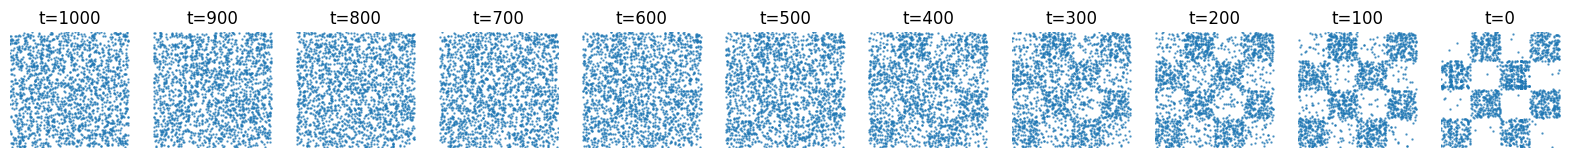

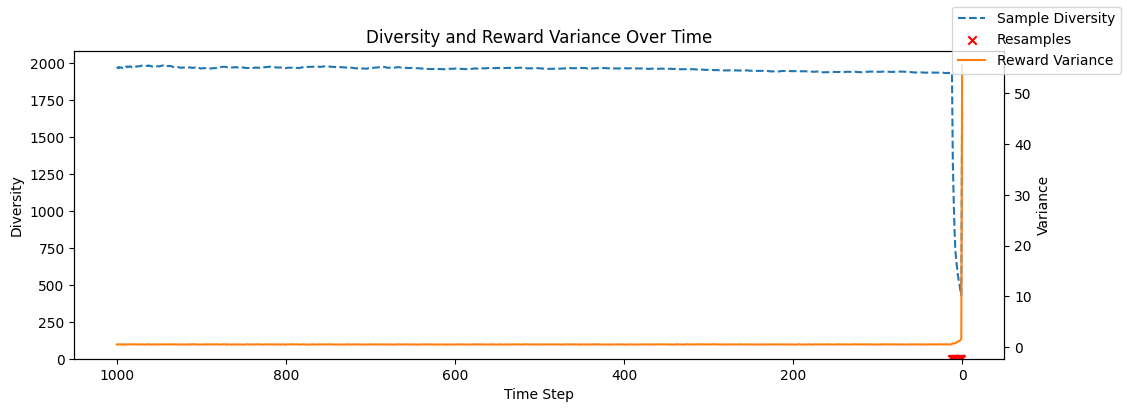

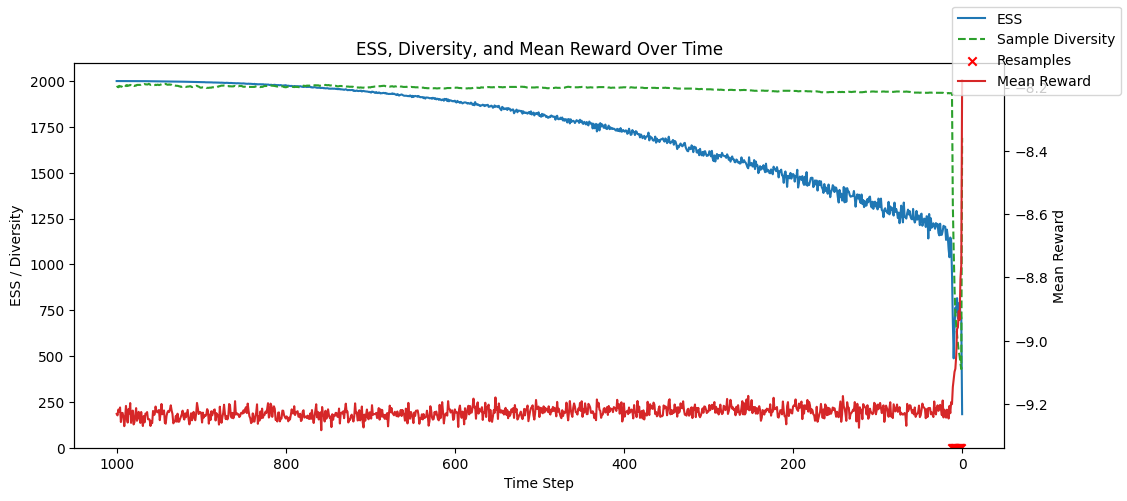

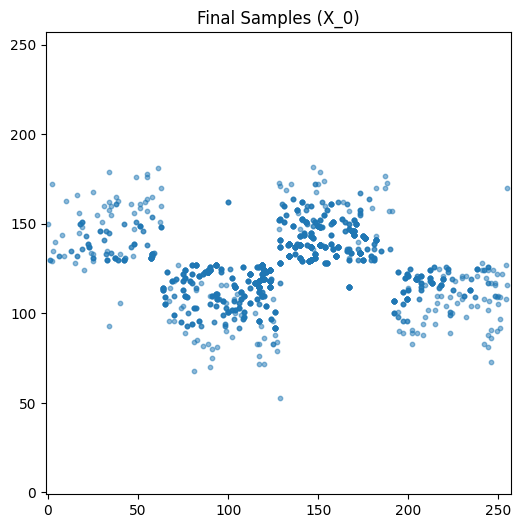

Final average reward: -0.8584
Final diversity: 477


In [13]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

## First order approximate proposal with gradient clipping

In [14]:
num_particles = 2000
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal_with_gradient_clipping(gradient_clip_value=10),
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=100,
    device=device,
    verbose=False,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:37, 26.61it/s]

  1%|          | 6/1000 [00:00<00:37, 26.58it/s]

  1%|          | 9/1000 [00:00<00:37, 26.60it/s]

  1%|          | 12/1000 [00:00<00:37, 26.61it/s]

  2%|▏         | 15/1000 [00:00<00:37, 26.61it/s]

  2%|▏         | 18/1000 [00:00<00:36, 26.61it/s]

  2%|▏         | 21/1000 [00:00<00:36, 26.60it/s]

  2%|▏         | 24/1000 [00:00<00:36, 26.59it/s]

  3%|▎         | 27/1000 [00:01<00:36, 26.59it/s]

  3%|▎         | 30/1000 [00:01<00:36, 26.60it/s]

  3%|▎         | 33/1000 [00:01<00:36, 26.59it/s]

  4%|▎         | 36/1000 [00:01<00:36, 26.60it/s]

  4%|▍         | 39/1000 [00:01<00:36, 26.60it/s]

  4%|▍         | 42/1000 [00:01<00:36, 26.60it/s]

  4%|▍         | 45/1000 [00:01<00:35, 26.60it/s]

  5%|▍         | 48/1000 [00:01<00:35, 26.59it/s]

  5%|▌         | 51/1000 [00:01<00:35, 26.59it/s]

  5%|▌         | 54/1000 [00:02<00:35, 26.58it/s]

  6%|▌         | 57/1000 [00:02<00:35, 26.58it/s]

  6%|▌         | 60/1000 [00:02<00:35, 26.57it/s]

  6%|▋         | 63/1000 [00:02<00:35, 26.59it/s]

  7%|▋         | 66/1000 [00:02<00:35, 26.59it/s]

  7%|▋         | 69/1000 [00:02<00:35, 26.59it/s]

  7%|▋         | 72/1000 [00:02<00:34, 26.59it/s]

  8%|▊         | 75/1000 [00:02<00:34, 26.58it/s]

  8%|▊         | 78/1000 [00:02<00:34, 26.57it/s]

  8%|▊         | 81/1000 [00:03<00:34, 26.61it/s]

  8%|▊         | 84/1000 [00:03<00:34, 26.60it/s]

  9%|▊         | 87/1000 [00:03<00:34, 26.60it/s]

  9%|▉         | 90/1000 [00:03<00:34, 26.58it/s]

  9%|▉         | 93/1000 [00:03<00:34, 26.58it/s]

 10%|▉         | 96/1000 [00:03<00:34, 26.58it/s]

 10%|▉         | 99/1000 [00:03<00:33, 26.58it/s]

 10%|█         | 102/1000 [00:03<00:33, 26.59it/s]

 10%|█         | 105/1000 [00:03<00:33, 26.58it/s]

 11%|█         | 108/1000 [00:04<00:33, 26.58it/s]

 11%|█         | 111/1000 [00:04<00:33, 26.58it/s]

 11%|█▏        | 114/1000 [00:04<00:33, 26.57it/s]

 12%|█▏        | 117/1000 [00:04<00:33, 26.58it/s]

 12%|█▏        | 120/1000 [00:04<00:33, 26.61it/s]

 12%|█▏        | 123/1000 [00:04<00:32, 26.61it/s]

 13%|█▎        | 126/1000 [00:04<00:32, 26.60it/s]

 13%|█▎        | 129/1000 [00:04<00:32, 26.62it/s]

 13%|█▎        | 132/1000 [00:04<00:32, 26.61it/s]

 14%|█▎        | 135/1000 [00:05<00:32, 26.61it/s]

 14%|█▍        | 138/1000 [00:05<00:32, 26.62it/s]

 14%|█▍        | 141/1000 [00:05<00:32, 26.62it/s]

 14%|█▍        | 144/1000 [00:05<00:32, 26.62it/s]

 15%|█▍        | 147/1000 [00:05<00:32, 26.62it/s]

 15%|█▌        | 150/1000 [00:05<00:31, 26.61it/s]

 15%|█▌        | 153/1000 [00:05<00:31, 26.61it/s]

 16%|█▌        | 156/1000 [00:05<00:31, 26.61it/s]

 16%|█▌        | 159/1000 [00:05<00:31, 26.61it/s]

 16%|█▌        | 162/1000 [00:06<00:31, 26.61it/s]

 16%|█▋        | 165/1000 [00:06<00:31, 26.61it/s]

 17%|█▋        | 168/1000 [00:06<00:31, 26.60it/s]

 17%|█▋        | 171/1000 [00:06<00:31, 26.60it/s]

 17%|█▋        | 174/1000 [00:06<00:31, 26.60it/s]

 18%|█▊        | 177/1000 [00:06<00:30, 26.60it/s]

 18%|█▊        | 180/1000 [00:06<00:30, 26.59it/s]

 18%|█▊        | 183/1000 [00:06<00:30, 26.59it/s]

 19%|█▊        | 186/1000 [00:06<00:30, 26.59it/s]

 19%|█▉        | 189/1000 [00:07<00:30, 26.59it/s]

 19%|█▉        | 192/1000 [00:07<00:30, 26.60it/s]

 20%|█▉        | 195/1000 [00:07<00:30, 26.59it/s]

 20%|█▉        | 198/1000 [00:07<00:30, 26.58it/s]

 20%|██        | 201/1000 [00:07<00:30, 26.59it/s]

 20%|██        | 204/1000 [00:07<00:29, 26.59it/s]

 21%|██        | 207/1000 [00:07<00:29, 26.59it/s]

 21%|██        | 210/1000 [00:07<00:29, 26.60it/s]

 21%|██▏       | 213/1000 [00:08<00:29, 26.59it/s]

 22%|██▏       | 216/1000 [00:08<00:29, 26.59it/s]

 22%|██▏       | 219/1000 [00:08<00:29, 26.58it/s]

 22%|██▏       | 222/1000 [00:08<00:29, 26.59it/s]

 22%|██▎       | 225/1000 [00:08<00:29, 26.59it/s]

 23%|██▎       | 228/1000 [00:08<00:29, 26.60it/s]

 23%|██▎       | 231/1000 [00:08<00:28, 26.60it/s]

 23%|██▎       | 234/1000 [00:08<00:28, 26.60it/s]

 24%|██▎       | 237/1000 [00:08<00:28, 26.57it/s]

 24%|██▍       | 240/1000 [00:09<00:28, 26.48it/s]

 24%|██▍       | 243/1000 [00:09<00:28, 26.51it/s]

 25%|██▍       | 246/1000 [00:09<00:28, 26.54it/s]

 25%|██▍       | 249/1000 [00:09<00:28, 26.55it/s]

 25%|██▌       | 252/1000 [00:09<00:28, 26.56it/s]

 26%|██▌       | 255/1000 [00:09<00:28, 26.57it/s]

 26%|██▌       | 258/1000 [00:09<00:27, 26.57it/s]

 26%|██▌       | 261/1000 [00:09<00:27, 26.58it/s]

 26%|██▋       | 264/1000 [00:09<00:27, 26.59it/s]

 27%|██▋       | 267/1000 [00:10<00:27, 26.59it/s]

 27%|██▋       | 270/1000 [00:10<00:27, 26.60it/s]

 27%|██▋       | 273/1000 [00:10<00:27, 26.60it/s]

 28%|██▊       | 276/1000 [00:10<00:27, 26.54it/s]

 28%|██▊       | 279/1000 [00:10<00:27, 26.55it/s]

 28%|██▊       | 282/1000 [00:10<00:27, 26.56it/s]

 28%|██▊       | 285/1000 [00:10<00:26, 26.57it/s]

 29%|██▉       | 288/1000 [00:10<00:26, 26.51it/s]

 29%|██▉       | 291/1000 [00:10<00:26, 26.54it/s]

 29%|██▉       | 294/1000 [00:11<00:26, 26.54it/s]

 30%|██▉       | 297/1000 [00:11<00:26, 26.56it/s]

 30%|███       | 300/1000 [00:11<00:26, 26.59it/s]

 30%|███       | 303/1000 [00:11<00:26, 26.59it/s]

 31%|███       | 306/1000 [00:11<00:26, 26.59it/s]

 31%|███       | 309/1000 [00:11<00:25, 26.60it/s]

 31%|███       | 312/1000 [00:11<00:25, 26.61it/s]

 32%|███▏      | 315/1000 [00:11<00:25, 26.61it/s]

 32%|███▏      | 318/1000 [00:11<00:25, 26.61it/s]

 32%|███▏      | 321/1000 [00:12<00:25, 26.62it/s]

 32%|███▏      | 324/1000 [00:12<00:25, 26.62it/s]

 33%|███▎      | 327/1000 [00:12<00:25, 26.62it/s]

 33%|███▎      | 330/1000 [00:12<00:25, 26.62it/s]

 33%|███▎      | 333/1000 [00:12<00:25, 26.62it/s]

 34%|███▎      | 336/1000 [00:12<00:24, 26.61it/s]

 34%|███▍      | 339/1000 [00:12<00:24, 26.63it/s]

 34%|███▍      | 342/1000 [00:12<00:24, 26.63it/s]

 34%|███▍      | 345/1000 [00:12<00:24, 26.63it/s]

 35%|███▍      | 348/1000 [00:13<00:24, 26.59it/s]

 35%|███▌      | 351/1000 [00:13<00:24, 26.61it/s]

 35%|███▌      | 354/1000 [00:13<00:24, 26.60it/s]

 36%|███▌      | 357/1000 [00:13<00:24, 26.60it/s]

 36%|███▌      | 360/1000 [00:13<00:24, 26.60it/s]

 36%|███▋      | 363/1000 [00:13<00:23, 26.59it/s]

 37%|███▋      | 366/1000 [00:13<00:23, 26.59it/s]

 37%|███▋      | 369/1000 [00:13<00:23, 26.60it/s]

 37%|███▋      | 372/1000 [00:13<00:23, 26.60it/s]

 38%|███▊      | 375/1000 [00:14<00:23, 26.59it/s]

 38%|███▊      | 378/1000 [00:14<00:23, 26.59it/s]

 38%|███▊      | 381/1000 [00:14<00:23, 26.58it/s]

 38%|███▊      | 384/1000 [00:14<00:23, 26.56it/s]

 39%|███▊      | 387/1000 [00:14<00:23, 26.57it/s]

 39%|███▉      | 390/1000 [00:14<00:22, 26.58it/s]

 39%|███▉      | 393/1000 [00:14<00:22, 26.58it/s]

 40%|███▉      | 396/1000 [00:14<00:22, 26.59it/s]

 40%|███▉      | 399/1000 [00:15<00:22, 26.60it/s]

 40%|████      | 402/1000 [00:15<00:22, 26.60it/s]

 40%|████      | 405/1000 [00:15<00:22, 26.61it/s]

 41%|████      | 408/1000 [00:15<00:22, 26.60it/s]

 41%|████      | 411/1000 [00:15<00:22, 26.59it/s]

 41%|████▏     | 414/1000 [00:15<00:22, 26.60it/s]

 42%|████▏     | 417/1000 [00:15<00:21, 26.60it/s]

 42%|████▏     | 420/1000 [00:15<00:21, 26.60it/s]

 42%|████▏     | 423/1000 [00:15<00:21, 26.60it/s]

 43%|████▎     | 426/1000 [00:16<00:21, 26.59it/s]

 43%|████▎     | 429/1000 [00:16<00:21, 26.59it/s]

 43%|████▎     | 432/1000 [00:16<00:21, 26.59it/s]

 44%|████▎     | 435/1000 [00:16<00:21, 26.60it/s]

 44%|████▍     | 438/1000 [00:16<00:21, 26.60it/s]

 44%|████▍     | 441/1000 [00:16<00:21, 26.60it/s]

 44%|████▍     | 444/1000 [00:16<00:20, 26.61it/s]

 45%|████▍     | 447/1000 [00:16<00:20, 26.61it/s]

 45%|████▌     | 450/1000 [00:16<00:20, 26.61it/s]

 45%|████▌     | 453/1000 [00:17<00:20, 26.58it/s]

 46%|████▌     | 456/1000 [00:17<00:20, 26.58it/s]

 46%|████▌     | 459/1000 [00:17<00:20, 26.57it/s]

 46%|████▌     | 462/1000 [00:17<00:20, 26.58it/s]

 46%|████▋     | 465/1000 [00:17<00:20, 26.58it/s]

 47%|████▋     | 468/1000 [00:17<00:20, 26.59it/s]

 47%|████▋     | 471/1000 [00:17<00:19, 26.58it/s]

 47%|████▋     | 474/1000 [00:17<00:19, 26.57it/s]

 48%|████▊     | 477/1000 [00:17<00:19, 26.57it/s]

 48%|████▊     | 480/1000 [00:18<00:19, 26.60it/s]

 48%|████▊     | 483/1000 [00:18<00:19, 26.60it/s]

 49%|████▊     | 486/1000 [00:18<00:19, 26.60it/s]

 49%|████▉     | 489/1000 [00:18<00:19, 26.59it/s]

 49%|████▉     | 492/1000 [00:18<00:19, 26.58it/s]

 50%|████▉     | 495/1000 [00:18<00:18, 26.58it/s]

 50%|████▉     | 498/1000 [00:18<00:18, 26.58it/s]

 50%|█████     | 501/1000 [00:18<00:18, 26.57it/s]

 50%|█████     | 504/1000 [00:18<00:18, 26.57it/s]

 51%|█████     | 507/1000 [00:19<00:18, 26.59it/s]

 51%|█████     | 510/1000 [00:19<00:18, 26.58it/s]

 51%|█████▏    | 513/1000 [00:19<00:18, 26.59it/s]

 52%|█████▏    | 516/1000 [00:19<00:18, 26.58it/s]

 52%|█████▏    | 519/1000 [00:19<00:18, 26.57it/s]

 52%|█████▏    | 522/1000 [00:19<00:17, 26.57it/s]

 52%|█████▎    | 525/1000 [00:19<00:17, 26.57it/s]

 53%|█████▎    | 528/1000 [00:19<00:17, 26.58it/s]

 53%|█████▎    | 531/1000 [00:19<00:17, 26.59it/s]

 53%|█████▎    | 534/1000 [00:20<00:17, 26.59it/s]

 54%|█████▎    | 537/1000 [00:20<00:17, 26.57it/s]

 54%|█████▍    | 540/1000 [00:20<00:17, 26.57it/s]

 54%|█████▍    | 543/1000 [00:20<00:17, 26.59it/s]

 55%|█████▍    | 546/1000 [00:20<00:17, 26.59it/s]

 55%|█████▍    | 549/1000 [00:20<00:16, 26.60it/s]

 55%|█████▌    | 552/1000 [00:20<00:16, 26.59it/s]

 56%|█████▌    | 555/1000 [00:20<00:16, 26.59it/s]

 56%|█████▌    | 558/1000 [00:20<00:16, 26.60it/s]

 56%|█████▌    | 561/1000 [00:21<00:16, 26.61it/s]

 56%|█████▋    | 564/1000 [00:21<00:16, 26.61it/s]

 57%|█████▋    | 567/1000 [00:21<00:16, 26.61it/s]

 57%|█████▋    | 570/1000 [00:21<00:16, 26.61it/s]

 57%|█████▋    | 573/1000 [00:21<00:16, 26.61it/s]

 58%|█████▊    | 576/1000 [00:21<00:15, 26.61it/s]

 58%|█████▊    | 579/1000 [00:21<00:15, 26.64it/s]

 58%|█████▊    | 582/1000 [00:21<00:15, 26.66it/s]

 58%|█████▊    | 585/1000 [00:21<00:15, 26.67it/s]

 59%|█████▉    | 588/1000 [00:22<00:15, 26.69it/s]

 59%|█████▉    | 591/1000 [00:22<00:15, 26.69it/s]

 59%|█████▉    | 594/1000 [00:22<00:15, 26.69it/s]

 60%|█████▉    | 597/1000 [00:22<00:15, 26.67it/s]

 60%|██████    | 600/1000 [00:22<00:15, 26.65it/s]

 60%|██████    | 603/1000 [00:22<00:14, 26.64it/s]

 61%|██████    | 606/1000 [00:22<00:14, 26.63it/s]

 61%|██████    | 609/1000 [00:22<00:14, 26.62it/s]

 61%|██████    | 612/1000 [00:23<00:14, 26.59it/s]

 62%|██████▏   | 615/1000 [00:23<00:14, 26.58it/s]

 62%|██████▏   | 618/1000 [00:23<00:14, 26.61it/s]

 62%|██████▏   | 621/1000 [00:23<00:14, 26.59it/s]

 62%|██████▏   | 624/1000 [00:23<00:14, 26.61it/s]

 63%|██████▎   | 627/1000 [00:23<00:14, 26.61it/s]

 63%|██████▎   | 630/1000 [00:23<00:13, 26.62it/s]

 63%|██████▎   | 633/1000 [00:23<00:13, 26.62it/s]

 64%|██████▎   | 636/1000 [00:23<00:13, 26.61it/s]

 64%|██████▍   | 639/1000 [00:24<00:13, 26.63it/s]

 64%|██████▍   | 642/1000 [00:24<00:13, 26.62it/s]

 64%|██████▍   | 645/1000 [00:24<00:13, 26.64it/s]

 65%|██████▍   | 648/1000 [00:24<00:13, 26.64it/s]

 65%|██████▌   | 651/1000 [00:24<00:13, 26.63it/s]

 65%|██████▌   | 654/1000 [00:24<00:12, 26.62it/s]

 66%|██████▌   | 657/1000 [00:24<00:12, 26.61it/s]

 66%|██████▌   | 660/1000 [00:24<00:12, 26.61it/s]

 66%|██████▋   | 663/1000 [00:24<00:12, 26.61it/s]

 67%|██████▋   | 666/1000 [00:25<00:12, 26.61it/s]

 67%|██████▋   | 669/1000 [00:25<00:12, 26.60it/s]

 67%|██████▋   | 672/1000 [00:25<00:12, 26.61it/s]

 68%|██████▊   | 675/1000 [00:25<00:12, 26.61it/s]

 68%|██████▊   | 678/1000 [00:25<00:12, 26.61it/s]

 68%|██████▊   | 681/1000 [00:25<00:11, 26.60it/s]

 68%|██████▊   | 684/1000 [00:25<00:11, 26.60it/s]

 69%|██████▊   | 687/1000 [00:25<00:11, 26.61it/s]

 69%|██████▉   | 690/1000 [00:25<00:11, 26.61it/s]

 69%|██████▉   | 693/1000 [00:26<00:11, 26.62it/s]

 70%|██████▉   | 696/1000 [00:26<00:11, 26.62it/s]

 70%|██████▉   | 699/1000 [00:26<00:11, 26.61it/s]

 70%|███████   | 702/1000 [00:26<00:11, 26.62it/s]

 70%|███████   | 705/1000 [00:26<00:11, 26.61it/s]

 71%|███████   | 708/1000 [00:26<00:10, 26.62it/s]

 71%|███████   | 711/1000 [00:26<00:10, 26.61it/s]

 71%|███████▏  | 714/1000 [00:26<00:10, 26.63it/s]

 72%|███████▏  | 717/1000 [00:26<00:10, 26.63it/s]

 72%|███████▏  | 720/1000 [00:27<00:10, 26.62it/s]

 72%|███████▏  | 723/1000 [00:27<00:10, 26.63it/s]

 73%|███████▎  | 726/1000 [00:27<00:10, 26.62it/s]

 73%|███████▎  | 729/1000 [00:27<00:10, 26.61it/s]

 73%|███████▎  | 732/1000 [00:27<00:10, 26.62it/s]

 74%|███████▎  | 735/1000 [00:27<00:09, 26.61it/s]

 74%|███████▍  | 738/1000 [00:27<00:09, 26.61it/s]

 74%|███████▍  | 741/1000 [00:27<00:09, 26.61it/s]

 74%|███████▍  | 744/1000 [00:27<00:09, 26.63it/s]

 75%|███████▍  | 747/1000 [00:28<00:09, 26.63it/s]

 75%|███████▌  | 750/1000 [00:28<00:09, 26.61it/s]

 75%|███████▌  | 753/1000 [00:28<00:09, 26.61it/s]

 76%|███████▌  | 756/1000 [00:28<00:09, 26.62it/s]

 76%|███████▌  | 759/1000 [00:28<00:09, 26.60it/s]

 76%|███████▌  | 762/1000 [00:28<00:08, 26.60it/s]

 76%|███████▋  | 765/1000 [00:28<00:08, 26.60it/s]

 77%|███████▋  | 768/1000 [00:28<00:08, 26.61it/s]

 77%|███████▋  | 771/1000 [00:28<00:08, 26.61it/s]

 77%|███████▋  | 774/1000 [00:29<00:08, 26.61it/s]

 78%|███████▊  | 777/1000 [00:29<00:08, 26.60it/s]

 78%|███████▊  | 780/1000 [00:29<00:08, 26.61it/s]

 78%|███████▊  | 783/1000 [00:29<00:08, 26.61it/s]

 79%|███████▊  | 786/1000 [00:29<00:08, 26.59it/s]

 79%|███████▉  | 789/1000 [00:29<00:07, 26.59it/s]

 79%|███████▉  | 792/1000 [00:29<00:07, 26.60it/s]

 80%|███████▉  | 795/1000 [00:29<00:07, 26.61it/s]

 80%|███████▉  | 798/1000 [00:30<00:07, 26.61it/s]

 80%|████████  | 801/1000 [00:30<00:07, 26.62it/s]

 80%|████████  | 804/1000 [00:30<00:07, 26.62it/s]

 81%|████████  | 807/1000 [00:30<00:07, 26.64it/s]

 81%|████████  | 810/1000 [00:30<00:07, 26.66it/s]

 81%|████████▏ | 813/1000 [00:30<00:07, 26.65it/s]

 82%|████████▏ | 816/1000 [00:30<00:06, 26.62it/s]

 82%|████████▏ | 819/1000 [00:30<00:06, 26.62it/s]

 82%|████████▏ | 822/1000 [00:30<00:06, 26.62it/s]

 82%|████████▎ | 825/1000 [00:31<00:06, 26.62it/s]

 83%|████████▎ | 828/1000 [00:31<00:06, 26.64it/s]

 83%|████████▎ | 831/1000 [00:31<00:06, 26.63it/s]

 83%|████████▎ | 834/1000 [00:31<00:06, 26.62it/s]

 84%|████████▎ | 837/1000 [00:31<00:06, 26.62it/s]

 84%|████████▍ | 840/1000 [00:31<00:06, 26.60it/s]

 84%|████████▍ | 843/1000 [00:31<00:05, 26.63it/s]

 85%|████████▍ | 846/1000 [00:31<00:05, 26.63it/s]

 85%|████████▍ | 849/1000 [00:31<00:05, 26.62it/s]

 85%|████████▌ | 852/1000 [00:32<00:05, 26.61it/s]

 86%|████████▌ | 855/1000 [00:32<00:05, 26.61it/s]

 86%|████████▌ | 858/1000 [00:32<00:05, 26.62it/s]

 86%|████████▌ | 861/1000 [00:32<00:05, 26.62it/s]

 86%|████████▋ | 864/1000 [00:32<00:05, 26.62it/s]

 87%|████████▋ | 867/1000 [00:32<00:04, 26.61it/s]

 87%|████████▋ | 870/1000 [00:32<00:04, 26.61it/s]

 87%|████████▋ | 873/1000 [00:32<00:04, 26.60it/s]

 88%|████████▊ | 876/1000 [00:32<00:04, 26.60it/s]

 88%|████████▊ | 879/1000 [00:33<00:04, 26.59it/s]

 88%|████████▊ | 882/1000 [00:33<00:04, 26.59it/s]

 88%|████████▊ | 885/1000 [00:33<00:04, 26.60it/s]

 89%|████████▉ | 888/1000 [00:33<00:04, 26.60it/s]

 89%|████████▉ | 891/1000 [00:33<00:04, 26.59it/s]

 89%|████████▉ | 894/1000 [00:33<00:03, 26.58it/s]

 90%|████████▉ | 897/1000 [00:33<00:03, 26.60it/s]

 90%|█████████ | 900/1000 [00:33<00:03, 26.60it/s]

 90%|█████████ | 903/1000 [00:33<00:03, 26.60it/s]

 91%|█████████ | 906/1000 [00:34<00:03, 26.60it/s]

 91%|█████████ | 909/1000 [00:34<00:03, 26.59it/s]

 91%|█████████ | 912/1000 [00:34<00:03, 26.59it/s]

 92%|█████████▏| 915/1000 [00:34<00:03, 26.60it/s]

 92%|█████████▏| 918/1000 [00:34<00:03, 26.62it/s]

 92%|█████████▏| 921/1000 [00:34<00:02, 26.61it/s]

 92%|█████████▏| 924/1000 [00:34<00:02, 26.60it/s]

 93%|█████████▎| 927/1000 [00:34<00:02, 26.60it/s]

 93%|█████████▎| 930/1000 [00:34<00:02, 26.58it/s]

 93%|█████████▎| 933/1000 [00:35<00:02, 26.58it/s]

 94%|█████████▎| 936/1000 [00:35<00:02, 26.59it/s]

 94%|█████████▍| 939/1000 [00:35<00:02, 26.60it/s]

 94%|█████████▍| 942/1000 [00:35<00:02, 26.59it/s]

 94%|█████████▍| 945/1000 [00:35<00:02, 26.60it/s]

 95%|█████████▍| 948/1000 [00:35<00:01, 26.57it/s]

 95%|█████████▌| 951/1000 [00:35<00:01, 26.59it/s]

 95%|█████████▌| 954/1000 [00:35<00:01, 26.59it/s]

 96%|█████████▌| 957/1000 [00:35<00:01, 26.59it/s]

 96%|█████████▌| 960/1000 [00:36<00:01, 26.60it/s]

 96%|█████████▋| 963/1000 [00:36<00:01, 26.60it/s]

 97%|█████████▋| 966/1000 [00:36<00:01, 26.60it/s]

 97%|█████████▋| 969/1000 [00:36<00:01, 26.60it/s]

 97%|█████████▋| 972/1000 [00:36<00:01, 26.53it/s]

 98%|█████████▊| 975/1000 [00:36<00:00, 26.51it/s]

 98%|█████████▊| 978/1000 [00:36<00:00, 26.49it/s]

 98%|█████████▊| 981/1000 [00:36<00:00, 26.48it/s]

 98%|█████████▊| 984/1000 [00:36<00:00, 26.49it/s]

 99%|█████████▊| 987/1000 [00:37<00:00, 26.46it/s]

 99%|█████████▉| 990/1000 [00:37<00:00, 26.45it/s]

 99%|█████████▉| 993/1000 [00:37<00:00, 26.45it/s]

100%|█████████▉| 996/1000 [00:37<00:00, 26.45it/s]

100%|█████████▉| 999/1000 [00:37<00:00, 26.43it/s]

100%|██████████| 1000/1000 [00:37<00:00, 26.59it/s]

Resampled 31 times.


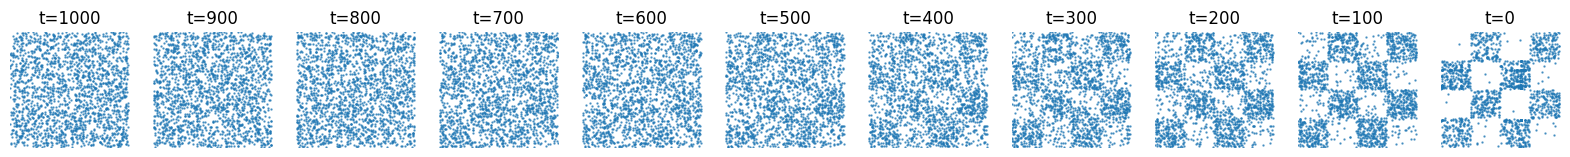

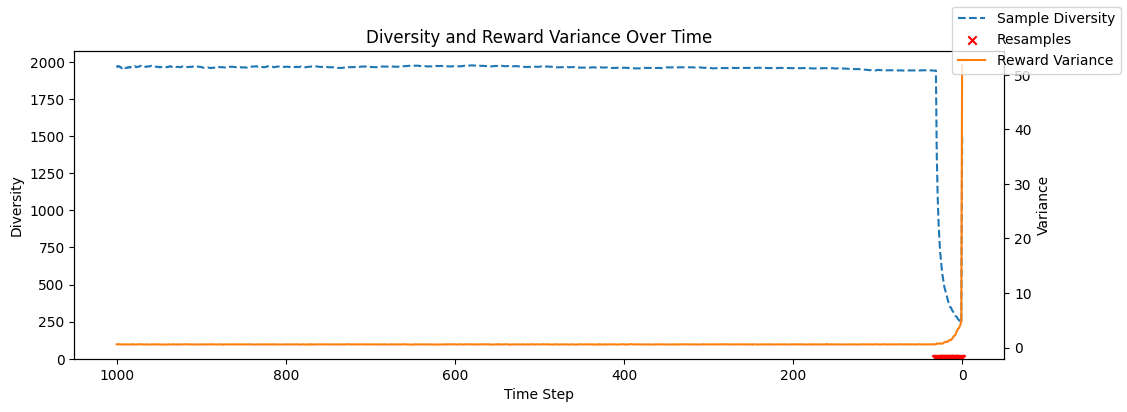

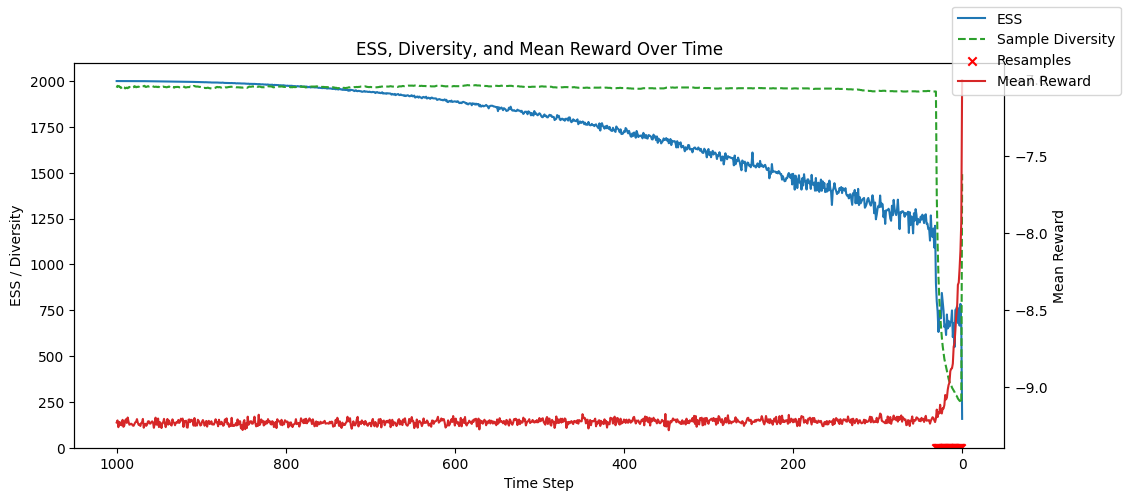

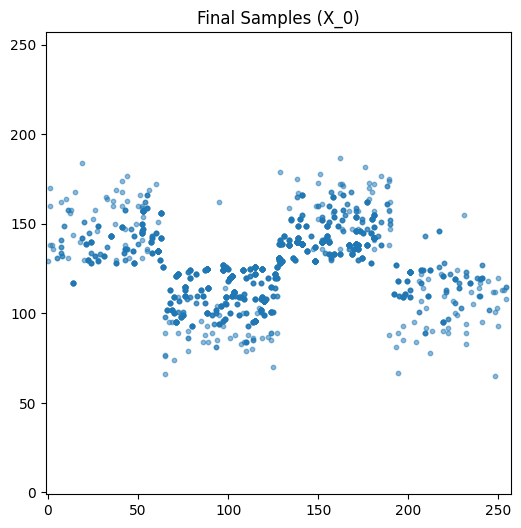

Final average reward: -1.0190
Final diversity: 460


In [15]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

### Use a reward function with bad gradients

In [16]:
def compute_rewards_bad(x: Tensor, with_grad=False):
    # x.shape : (B, 2, num_categories)
    
    original_reward = compute_rewards(x, with_grad=False)
    
    x = (x[:, : , :-1] * torch.arange(0, vocab_size, device=x.device)).sum(dim=-1)
    x = x / (vocab_size - 1)
    
    reward_x0 = - (x[:, 0] - 0.5) ** 2 * 10
    reward_x1 = - (x[:, 1] - 0.5) ** 2 * 100
    
    reward = reward_x0 + reward_x1
    
    assert torch.allclose(reward, original_reward)
    return reward


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [17]:
num_particles = 2000
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal_with_gradient_clipping(gradient_clip_value=10),
    compute_reward_fn=compute_rewards_bad,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=100,
    device=device,
    verbose=False,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:01<?, ?it/s]

RuntimeError: The size of tensor a (255) must match the size of tensor b (256) at non-singleton dimension 2

In [ ]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)